In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
#%matplotlib inline+

import json

from datetime import datetime,timedelta
#from sklearn.metrics import mean_squared_error
#from scipy.stats import norm
#from scipy.optimize import curve_fit
#from scipy.optimize import fsolve

#import folium

# BR / Brasil - geojson/geojs-100-mun.json
# AL / Alagoas - geojson/geojs-27-mun.json
# BA / Bahia - geojson/geojs-29-mun.json
# CE / Ceará - geojson/geojs-23-mun.json
# MA / Maranhão - geojson/geojs-21-mun.json
# PB / Paraíba - geojson/geojs-25-mun.json
# PE / Pernambuco - geojson/geojs-26-mun.json
# PI / Piauí - geojson/geojs-22-mun.json
# RN / Rio Grande do Norte - geojson/geojs-24-mun.json
# SE / Sergipe - geojson/geojs-28-mun.json

In [2]:
url_B = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
url_G = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

filename = url_B.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url_B)
    r.encoding = "UTF-8"
    f.write(r.content)
    
df = pd.read_csv(url_B.split("/")[-1], sep = ",")   

In [3]:
Norte = ["AC", "AM", "AP", "PA", "RO", "RR", "TO"]
Nordeste = ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']
Sudeste = ['ES', 'MG', 'RJ', 'SP']
Sul = ['PR', 'RS', 'SC']
Centro_oeste = ['DF', 'GO', 'MT', 'MS']

Regiao = [Nordeste, Norte, Sudeste, Sul, Centro_oeste]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

IFR_BR = [[['AL', 1.1], ['BA', 1.1], ['CE', 1.1], ['MA', 1], ['PB', 1.2], ['PE', 1.1], ['PI', 0], ['RN', 1.1], ['SE', 0]],
          [["AC", 0], ["AM", 0.8], ["AP", 0], ["PA", 0.9], ["RO", 0], ["RR", 0], ["TO", 0]],
          [['ES', 0.9], ['MG', 1], ['RJ', 0.8], ['SP', 0.7]],
          [['PR', 0], ['RS', 0.9], ['SC', 0.8]],
          [['DF', 0], ['GO', 0], ['MT', 0], ['MS', 0]]
         ]

In [4]:
df1 = df.drop(['is_repeated'], axis = 1).sort_values('date', ascending = True)
df1.rename(columns={'last_available_confirmed' : 'confirmed',
                    'last_available_confirmed_per_100k_inhabitants' : 'incidence',
                    'estimated_population_2019' : 'population',
                    'last_available_deaths' : 'deaths', 
                    'epidemiological_week' : 'week_count',
                    'last_available_death_rate' : 'death_rate', 
                    'order_for_place' : 'local_day'}, inplace = True)

In [5]:
df_hoje = df1.loc[df['is_last'] == True, :]

label = ["Cidade", "Código IBGE", "Dia", "Último Dado", "Casos Confirmados",
         "Incidência de Casos", "Mortalidade", "Óbitos Confirmados", "Estado",
         "Novos Casos", "Novas Mortes"]

color = ['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792']

color2 = ['#00876c', '#379469', '#58a066', '#78ab63', '#98b561', '#b8bf62', '#dac767',
          '#deb256', '#e09d4b', '#e18745', '#e06f45', '#dc574a', '#d43d51']

color3 = ['#00876c', '#4ea06d', '#84b76e', '#bbcd73', '#f4e07f', '#f4ba61', '#ef9250', 
          '#e5694c', '#d43d51']

In [6]:
for r, regiao in enumerate(Regiao) :
    for e, estado in enumerate(regiao) :
        df1.loc[df1['state'].eq(estado), 'region'] = reg[r]
        df1.loc[df1['state'].eq(IFR_BR[r][e][0]), 'IFR'] = IFR_BR[r][e][1]

In [7]:
FMT = '%Y-%m-%d'

date = df['date']
df1['day_count'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days + 1)

In [8]:
df_estados = df1.loc[df['city'].isnull(), :].drop(['place_type'], axis = 1)
df_estados.reset_index(drop = True, inplace = True)

df_estados = df_estados[['state', 'region', 'population', 'is_last', 'date', 'day_count', 'local_day',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'incidence', 'death_rate', 'IFR']]         
 
df_Brasil = df_estados.drop(['is_last', 'population', 'local_day', 'day_count'], axis = 1)
df_Brasil = df_Brasil.groupby('date').sum()

In [9]:
df_estados[df_estados['is_last']].drop(['is_last', 'local_day', 'population', 'day_count'], axis = 1).reset_index(drop = True ).head()

,state,region,date,confirmed,deaths,new_confirmed,new_deaths,incidence,death_rate,IFR
0,TO,Norte,2020-10-23,74118,1082,216,4,4660.78247,0.0146,0.0
1,RR,Norte,2020-10-23,55613,691,344,0,8810.94330,0.0124,0.0
2,RN,Nordeste,2020-10-23,80031,2571,204,4,2264.49529,0.0321,1.1
3,MS,Centro Oeste,2020-10-23,79599,1548,479,10,2833.31565,0.0194,0.0
4,SE,Nordeste,2020-10-24,83646,2168,239,5,3607.26265,0.0259,0.0


In [10]:
df_cidades = df1.loc[df['place_type'].eq('city'), :].drop(['place_type'], axis = 1)
df_cidades = df_cidades.loc[(df_cidades["city"] != 'Importados/Indefinidos'), :]

df_cidades = df_cidades[['city', 'state', 'region', 'population', 'is_last', 'date', 'local_day',
                         'confirmed', 'deaths', 'new_confirmed', 'new_deaths', 'day_count']]

In [11]:
df_cidades[df_cidades['is_last']].drop(['is_last', 'local_day'], axis = 1).reset_index(drop = True).head()

,city,state,region,population,date,confirmed,deaths,new_confirmed,new_deaths,day_count
0,Itiquira,MT,Centro Oeste,13345.0,2020-08-10,75,1,3,0,168
1,Itaúba,MT,Centro Oeste,3802.0,2020-08-10,43,3,0,1,168
2,Itanhangá,MT,Centro Oeste,6737.0,2020-08-10,35,0,0,0,168
3,Ipiranga do Norte,MT,Centro Oeste,7667.0,2020-08-10,222,2,3,0,168
4,Indiavaí,MT,Centro Oeste,2752.0,2020-08-10,12,0,0,0,168


In [12]:
label_estados = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia Brasil", "Dia Local", "Casos Confirmados",
                 "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

In [13]:
def Estimar_Casos(data, por_1M = True, todos_estados = True) :
    
    estados = list(data.loc[data['is_last'], ['state']].sort_values('state', ascending = True)['state'].unique())
    
    IFR_median = np.median(data.loc[data['is_last'], ['IFR']].loc[:, 'IFR'])
    
    casos, casos_last, casos_est, IFR = [], [], [], []
    
    for e, estado in enumerate(estados) :      

        IFR.append(data.loc[(data['state'] == estado) & (data['is_last']), ['IFR']].loc[:, 'IFR'].values[0])

        if (IFR[e] == 0) & todos_estados :
            IFR[e] = IFR_median
        
        casos.append(np.median(data.loc[(data['state'] == estado), 
                                            :].sort_values('day_count', ascending = True).iloc[:-1, 7].tail(7)))
        
        casos_last.append(np.median(data.loc[(data['state'] == estado), 
                                                 :].sort_values('day_count', ascending = True).iloc[:-8, 7].tail(14)))
        

        if (IFR[e] != 0) :

            mortes = np.median(data.loc[(data['state'] == estado),
                                        :].sort_values('day_count', ascending = True).iloc[:-1, 8].tail(7))
             
            casos_est.append((100 * mortes / IFR[e]) - casos[e])
        
        else :
            casos_est.append(0)
            
        if por_1M :
            pop = data.loc[(data['state'] == estado) & (data['is_last']), ['population']].loc[:, 'population'].values[0]
            
            casos[e] *= (10 ** 6) / pop
            casos_last[e] *= (10 ** 6) / pop
            casos_est[e] *= (10 ** 6) / pop    
        
        casos_max = max(casos) 
        casos_est_max = max(casos_est) + casos_max
        
    return estados, IFR, casos, casos_last, casos_est, casos_max, casos_est_max, por_1M

In [14]:
def Plot_Graficos_Estimativas(modelo, horizontal = False) :
    
    estados = modelo[0]
    IFR = modelo[1]
    y = modelo[2]
    y_last = modelo[3]
    y_est = modelo[4]
    y_max = modelo[5]
    y_est_max = modelo[6]
    por_1M = modelo[7]
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [16, 11]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        
    for e, estado in enumerate(estados) :
        
        alpha = 0.5
        if IFR[e] == 0 :
            alpha = 0.1

        ratio = y[e] / y_max
        
        if horizontal :
            if e == 0 :
                plt.barh(0, 1, label = 'Estimativa', color = (.3, .3, .3, .5))
                plt.barh(0, 1, label = 'Semana passada', color = (.3, .3, .3, .8))
            
            plt.barh(estado, y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.barh(estado, y_last[e], color = (.3, .3, .3, .3))

            if (IFR[e] != 0) :

                plt.barh(estado, y_est[e], left = y[e], color = color2[int(round(12 * ratio, 0))])

                plt.barh(estado, y_est[e], left = y[e], color = (.9, .9, .9, alpha))
            
            if por_1M :
                if (y[e] != 0) :
                    plt.text(y[e] + 500, estado, str(int(round(y[e]))), color = 'black',  
                                 fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
                    if IFR[e] != 0 :
                        plt.text(500 + y_est[e] + y[e], estado, str(int(round(y[e] + y_est[e]))), color = (0.1, 0.1, 0.1, 0.7),  
                                 fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
            else :
                if (y[e] != 0) :
                    plt.text(y[e] + 50000, estado, str(int(round(y[e]))), color = 'black',  
                                 fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
                    if IFR[e] != 0 :
                        plt.text(500000 + y_est[e] + y[e], estado, str(int(round(y[e] + y_est[e]))), color = (0.1, 0.1, 0.1, 0.7),  
                                 fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')                   
        else :
            if e == 0 :
                plt.bar(estado, 1, label = 'Estimativa', color = (.3, .3, .3, .3))
                plt.bar(estado, 1, label = 'Semana anterior', color = (.3, .3, .3, .5))

            plt.bar(estado, y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.bar(estado, y_last[e], color = (.3, .3, .3, .3))

            if (IFR[e] != 0) :
                plt.bar(estado, y_est[e], bottom = y[e], color = color2[int(round(12 * ratio, 0))])     

                plt.bar(estado, y_est[e], bottom = y[e], color = (.9, .9, .9, alpha))


            if por_1M :
                if (y[e] != 0) :
                    plt.text(estado, y[e] + 2500, str(int(round(y[e]))), color = 'black', rotation = 'vertical',
                                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
                    if IFR[e] != 0 :
                        plt.text(estado, 2500 + y[e] + y_est[e],
                                 str(int(round(y[e] + y_est[e]))), color = (0.1, 0.1, 0.1, 0.7), rotation = 'vertical',
                                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
            else :
                if (y[e] != 0) :
                    plt.text(estado, y[e] + 50000, str(int(round(y[e], 0))), color = 'black', rotation = 'vertical',
                                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
                    if IFR != 0 :
                        plt.text(estado, 550000 + y_est[e] + y[e], str(int(round(y[e] + y_est[e]))),
                                 color = (0.1, 0.1, 0.1, 0.7), rotation = 'vertical',
                                 fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')

    if horizontal :
        plt.ylabel('Estados')
        if por_1M :
            plt.title("Casos Confirmados por milhão de habitantes - Estimativa Brasil H")
            plt.xlabel("Casos Confirmados por milhão de habitante")
            plt.savefig('Graphics/Casos_Confirmados_Estimativa_1MH.png')
        else :
            plt.title("Casos Confirmados - Estimativa Brasil H")
            plt.xlabel("Casos Confirmados")
            plt.savefig('Graphics/Casos_Confirmados_Estimativa_H.png')
            plt.text(10000, -1.05, "total = " + str(int(round(sum(y_est) + sum(y), 0))), color = (0.1, 0.1, 0.1, 0.7),
                 fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
            
        plt.yticks(range(len(estados)), estados)
        plt.legend(fontsize = 12)
        plt.xlim(0, y_est_max * 1.5)
        
    else :           
        plt.xlabel('Estados')    
        if por_1M :
            plt.title("Casos Confirmados por milhão de habitantes - Estimativa Brasil")
            plt.ylabel("Casos Confirmados por milhão de habitantes")
            plt.savefig("Graphics/Casos_Confirmados_Estimativa_1M.png")
        else :
            plt.title("Casos Confirmados - Estimativa Brasil")
            plt.ylabel("Casos Confirmados")
            plt.savefig("Graphics/Casos_Confirmados_Estimativa.png")

        plt.legend(fontsize = 12)    
        plt.xlim(-2, 33)         
        plt.ylim(0, y_est_max * 1.2)

    plt.show()

In [15]:
def Estimar_Todos(data) :
    
    modelo1 = Estimar_Casos(data, True)
    Plot_Graficos_Estimativas(modelo1, True)
    Plot_Graficos_Estimativas(modelo1, False)
    
    modelo2 = Estimar_Casos(data, False)
    Plot_Graficos_Estimativas(modelo1, True)
    Plot_Graficos_Estimativas(modelo1, False)

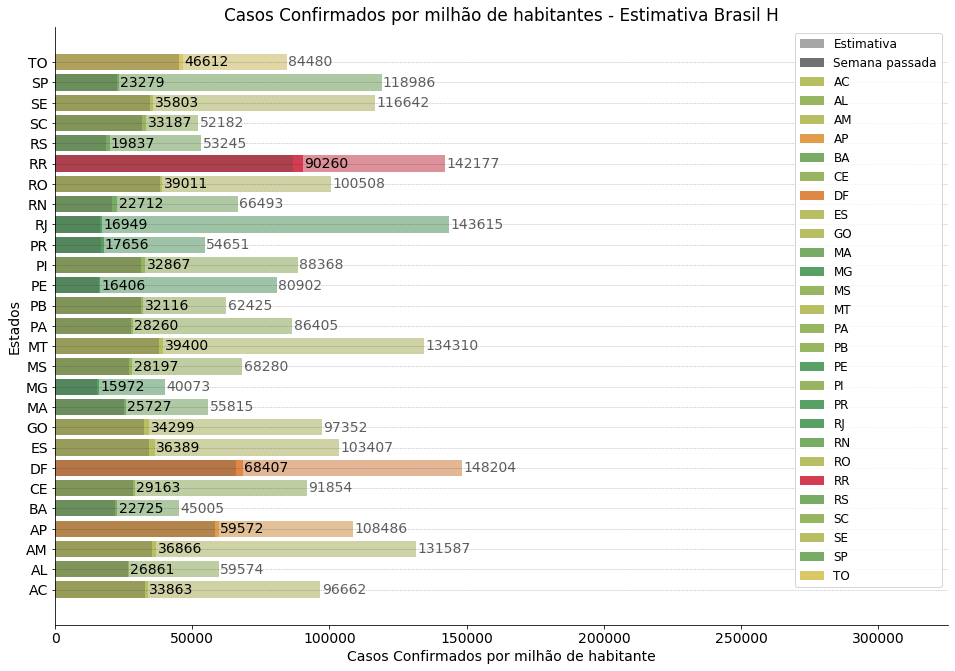

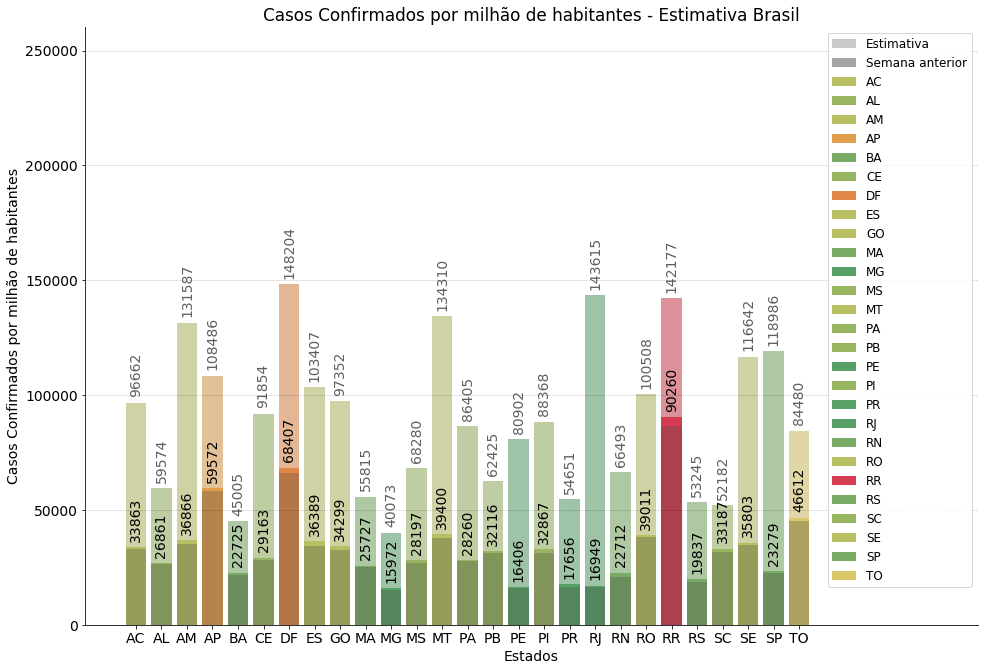

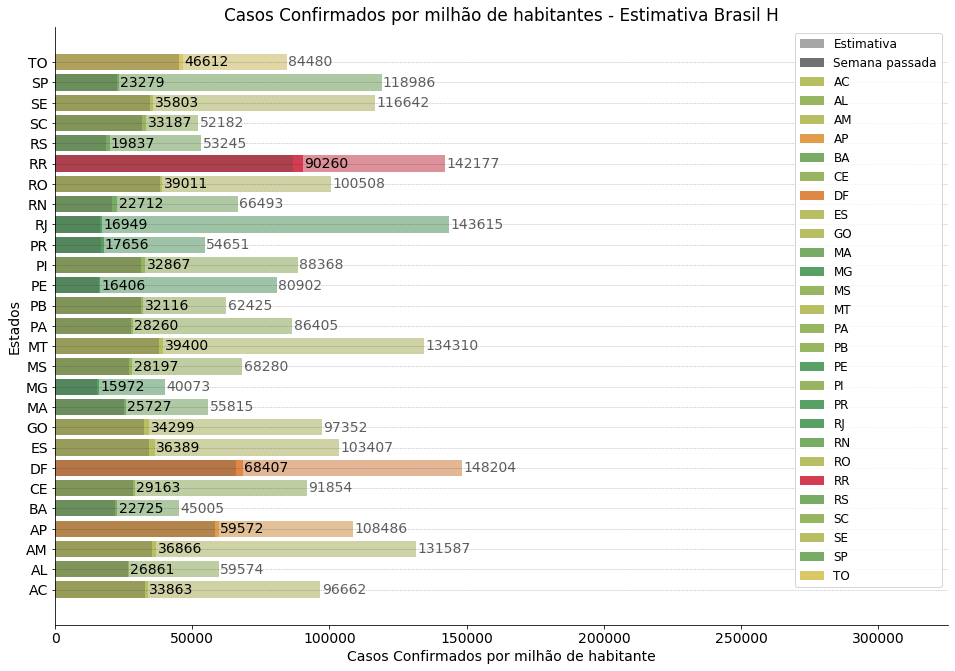

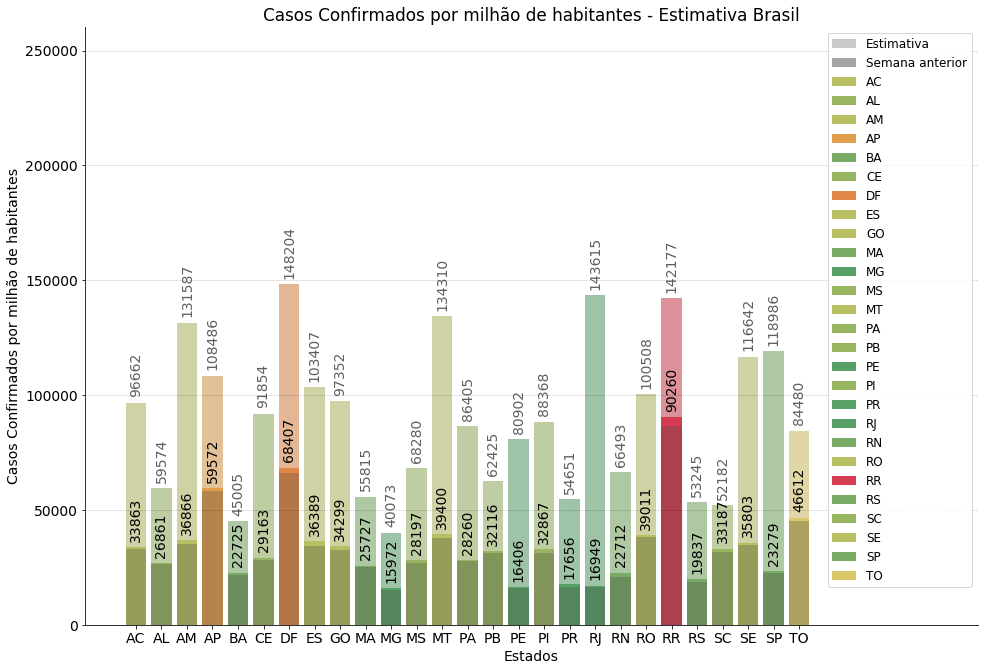

In [16]:
Estimar_Todos(df_estados)

In [17]:
def Obitos_per_capita(data, internacional = True) :
    
    estados = list(data.loc[data['is_last'], ['state']].sort_values('state', ascending = True)['state'].unique())
    
    mortes, mortes_last, mortes_pm, mortes_pm_last = [], [], [], []
    
    if internacional : 
        estados.extend(["Brasil", "EUA", "Bélgica"])
    
    for e, estado in enumerate(estados) :
        if e < 27 :
            pop = data.loc[(data['state'] == estado) & (data['is_last']), ['population']].loc[:, 'population'].values[0]

            mortes.append(np.median(data.loc[(data['state'] == estado), 
                                             :].sort_values('day_count', ascending = True).iloc[:-1, 8].tail(7)))

            mortes_last.append(np.median(data.loc[(data['state'] == estado), 
                                                  :].sort_values('day_count', ascending = True).iloc[:-8, 8].tail(14)))

            mortes_pm.append(mortes[e] * (10 ** 6) / pop)

            mortes_pm_last.append(mortes_last[e] * (10 ** 6) / pop) 
        elif estado == 'Brasil' : ### Dados dia 22/10
            mortes.append(156565)
            mortes_pm.append(735)
            mortes_last.append(0)
            mortes_pm_last.append(0)
        elif estado == 'EUA' :    ### Dados dia 22/10
            mortes.append(229971)
            mortes_pm.append(693)
            mortes_last.append(0)
            mortes_pm_last.append(0)
        else :                    ### Dados dia 22/10 Bélgica
            mortes.append(10658)
            mortes_pm.append(918)
            mortes_last.append(0)
            mortes_pm_last.append(0)            
                        
        mortes_max = max(mortes)
        mortes_pm_max = max(mortes_pm)
        
    return estados, mortes, mortes_last, mortes_pm, mortes_pm_last, mortes_max, mortes_pm_max

In [18]:
def Plot_Obitos_per_capita(modelo, horizontal = False, duplo = False) :
    
    estados = modelo[0]
    y = modelo[1]
    y_last = modelo[2]
    y2 = modelo[3]
    y2_last = modelo[4]
    y_max = modelo[5]
    y2_max = modelo[6]
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [16, 11]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        
    for e, estado in enumerate(estados) :

        ratio = y2[e] / y2_max
        
        if horizontal :
            if e == 0 :
                plt.barh(estado, 1, label = 'Semana passada', color = (.3, .3, .3, .8))
            
            plt.barh(estado, y2[e], label = estado, color = color2[int(round(12 * ratio, 0))])
    
            plt.barh(estado, y2_last[e], color = (.3, .3, .3, .3))

            plt.text(y2[e] + 32, estado, str(int(round(y2[e]))), color = 'black',  
                     fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
              
        else :
            if e == 0 :
                plt.bar(estado, 1, label = 'Semana anterior', color = (.3, .3, .3, .5))

            plt.bar(estado, y2[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.bar(estado, y2_last[e], color = (.3, .3, .3, .3))

            plt.text(estado, y2[e] + 32, str(int(round(y2[e]))), color = 'black', rotation = 'vertical',
                     fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')

    if horizontal :
        plt.ylabel('Estados')
        plt.title("Óbitos per capita no Brasil H")
        plt.xlabel("Óbitos por milhão de habitante")
        plt.savefig('Graphics/Obitos_per_capita_H.png')
            
        plt.yticks(range(len(estados)), estados)
        plt.legend(fontsize = 11)
        plt.xlim(0, y2_max * 1.5)
        
    else :           
        plt.xlabel('Estados')    
        plt.title("Óbitos per capita no Brasil")
        plt.xlabel("Óbitos por milhão de habitante")
        plt.savefig('Graphics/Obitos_per_capita.png')

        plt.legend(fontsize = 11)
        plt.xlim(-2, len(estados) + 6)
        plt.xticks(estados, rotation='vertical')
        plt.ylim(0, y2_max * 1.2)

    plt.show()

In [19]:
def Obitos_per_capita_completo(data) :
    
    modelo3 = Obitos_per_capita(data)
    Plot_Obitos_per_capita(modelo3, True)
    Plot_Obitos_per_capita(modelo3, False)

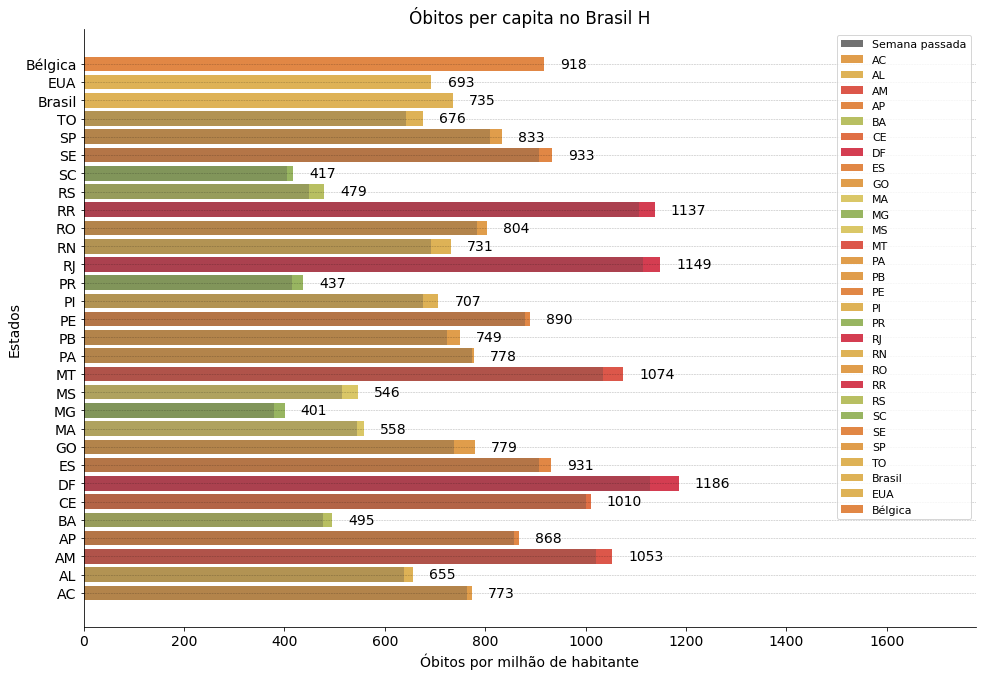

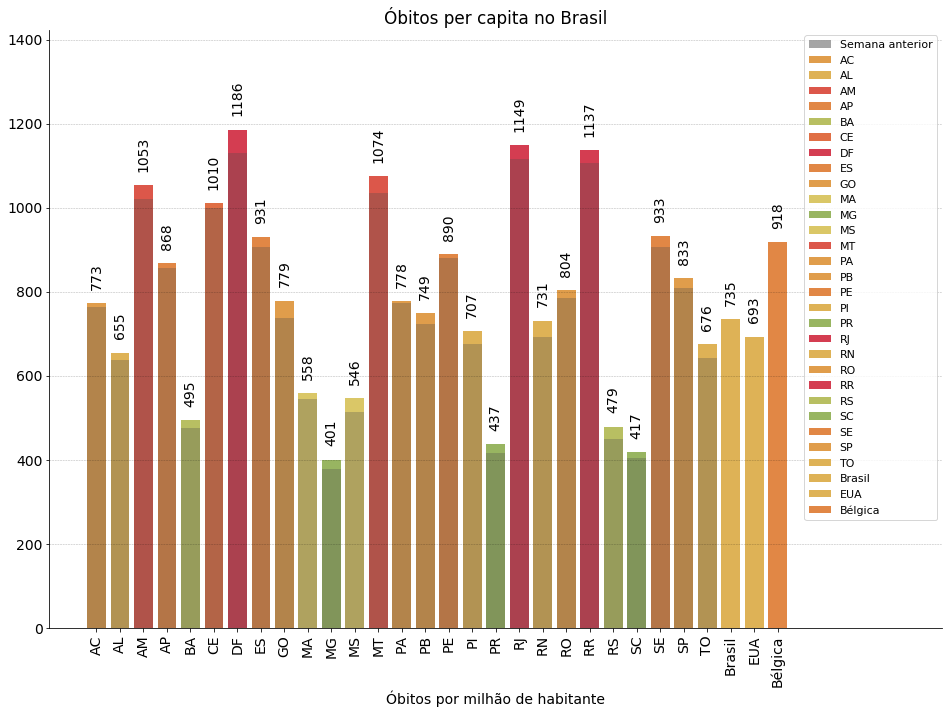

In [20]:
Obitos_per_capita_completo(df_estados)

In [21]:
### Plotar Mortes no mesmo gráfico do per capita
# fig, ax1 = plt.subplots()

# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('exp', color=color)
# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

# fig = plt.figure() # Create matplotlib figure

# ax = fig.add_subplot(111) # Create matplotlib axes
# ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

# width = 0.4

# df.amount.plot(kind='bar', color='red', ax=ax, width=width, position=1)
# df.price.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

# ax.set_ylabel('Amount')
# ax2.set_ylabel('Price')

# plt.show()

In [22]:
def Graficos_gerais(data, dado = 'casos', por_1M = False) :
    
    estados = list(data.loc[data['is_last'], ['state']].sort_values('state', ascending = True)['state'].unique())
    
    y, y_last = [], []
    
    #dado.replace({'casos' : 7, 'mortes' : 8, 'novos_casos' : 9, 'novas_mortes' : 10})
    if dado == 'novas_mortes' :
        dado = 10
    elif dado == 'novos_casos' :
        dado = 9
    elif dado == 'mortes' :
        dado = 8
    else :
        dado = 7
    
    for e, estado in enumerate(estados) :
            
        y.append(np.median(data.loc[(data['state'] == estado), 
                                        :].sort_values('day_count', ascending = True).iloc[:-1, dado].tail(7)))

        y_last.append(np.median(data.loc[(data['state'] == estado), 
                                             :].sort_values('day_count', ascending = True).iloc[:-8, dado].tail(14)))

        if por_1M :
            pop = data.loc[(data['state'] == estado) & (data['is_last']),
                               ['population']].loc[:, 'population'].values[0]
            
            y[e] *= (10 ** 6) / pop
            y_last[e] *= (10 ** 6) / pop

        y_max = max(y)
        
    return estados, dado, por_1M, y, y_last, y_max

In [23]:
def Plot_Graficos_gerais(modelo, horizontal = False, duplo = False) :
    
    estados = modelo[0]
    label = modelo[1]
    por_1M = modelo[2]
    y = modelo[3]
    y_last = modelo[4]
    y_max = modelo[5]
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [16, 11]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        
    for e, estado in enumerate(estados) :
        
        ratio = y[e] / y_max
        
        if horizontal :
            if e == 0 :
                plt.barh(estado, 1, label = 'Semana passada', color = (.3, .3, .3, .8))

            plt.barh(estado, y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.barh(estado, y_last[e], color = (.3, .3, .3, .3))
            if por_1M :
                plt.text(y[e] + y_max * .01, estado, str(int(round(y[e]))), color = 'black',  
                         fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')
            else :
                plt.text(y[e] + y_max * .01, estado, str(int(round(y[e]))), color = 'black',  
                         fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')

        else :
            if e == 0 :
                plt.bar(estado, 1, label = 'Semana anterior', color = (.3, .3, .3, .5))

            plt.bar(estado, y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.bar(estado, y_last[e], color = (.3, .3, .3, .3))
            
            if por_1M :
                plt.text(estado, y[e] + y_max * .01, str(int(round(y[e]))), color = 'black', rotation = 'vertical',
                         fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')
            else :
                plt.text(estado, y[e] + y_max * .01, str(int(round(y[e]))), color = 'black', rotation = 'vertical',
                         fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')

    if horizontal :
        if por_1M :
            plt.ylabel('Estados')
            plt.title(label_estados[label] + " por milhão no Brasil H")
            plt.xlabel(label_estados[label] + ' por milhão')
            plt.savefig('Graphics/' + label_estados[label] + '_1MH.png')

            plt.yticks(range(len(estados)), estados)
            plt.legend(fontsize = 12)
            plt.xlim(0, y_max * 1.5)
        else :
            plt.ylabel('Estados')
            plt.title(label_estados[label] + " no Brasil H")
            plt.xlabel(label_estados[label])
            plt.savefig('Graphics/' + label_estados[label] + '_H.png')

            plt.yticks(range(len(estados)), estados)
            plt.legend(fontsize = 12)
            plt.xlim(0, y_max * 1.5)
        
    else :
        if por_1M :
            plt.xlabel('Estados')    
            plt.title(label_estados[label] + " por milhão no Brasil")
            plt.ylabel(label_estados[label] + ' por milhão')
            plt.savefig('Graphics/' + label_estados[label] + '1M.png')

            plt.legend(fontsize = 12)
            plt.xlim(-2, len(estados) + 6)
            plt.ylim(0, y_max * 1.5)
        else :
            plt.xlabel('Estados')    
            plt.title(label_estados[label] + " no Brasil")
            plt.ylabel(label_estados[label])
            plt.savefig('Graphics/' + label_estados[label] + '.png')

            plt.legend(fontsize = 12)
            plt.xlim(-2, len(estados) + 6)
            plt.ylim(0, y_max * 1.5)

    plt.show()

In [24]:
def Graficos_gerais_completo(data) :
    dados = ['casos', 'mortes', 'novos_casos', 'novas_mortes']
    for dado in dados :
        modelg = Graficos_gerais(data, dado)
        Plot_Graficos_gerais(modelg, True)
        Plot_Graficos_gerais(modelg, False)
        
        modelg = Graficos_gerais(data, dado, True)
        Plot_Graficos_gerais(modelg, True)
        Plot_Graficos_gerais(modelg, False)

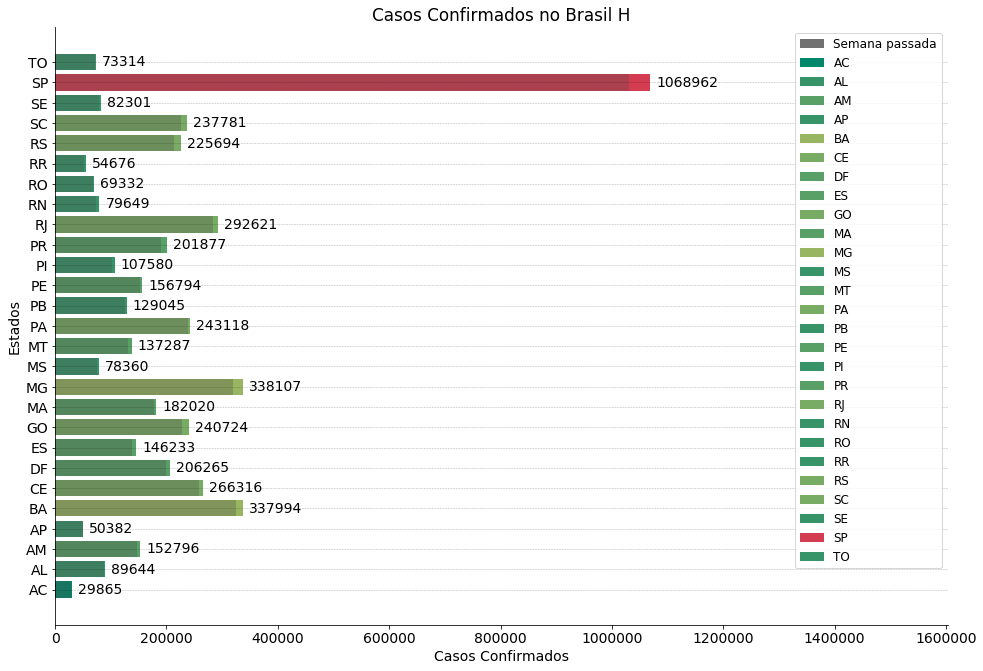

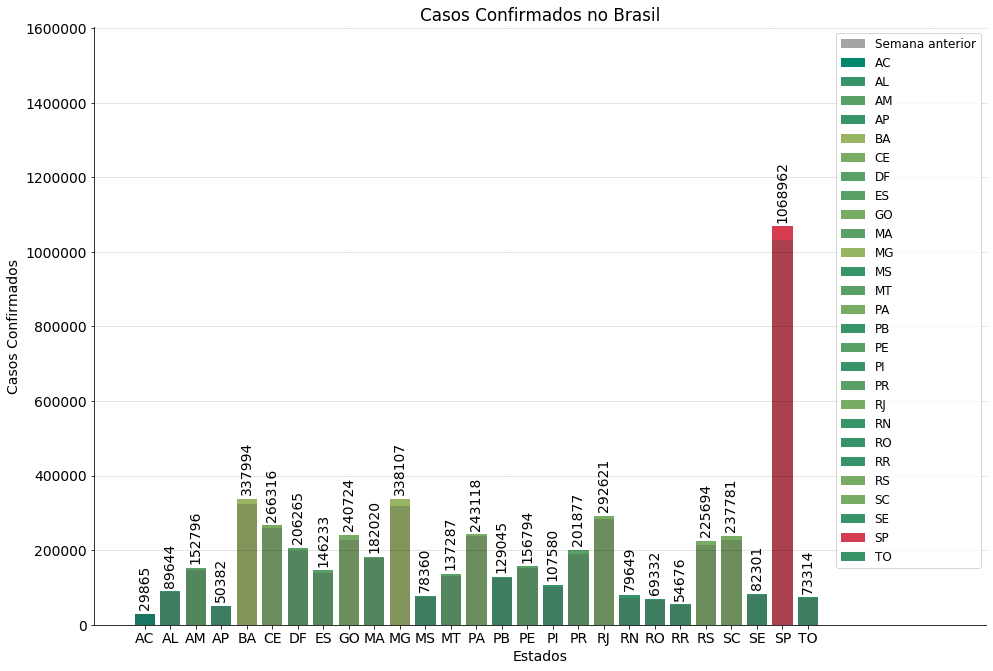

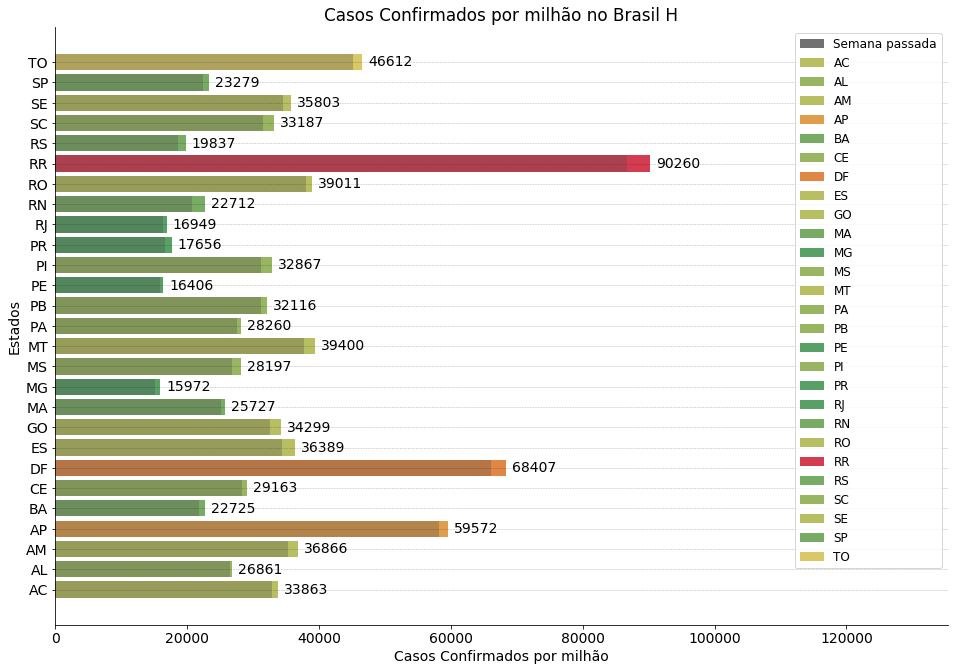

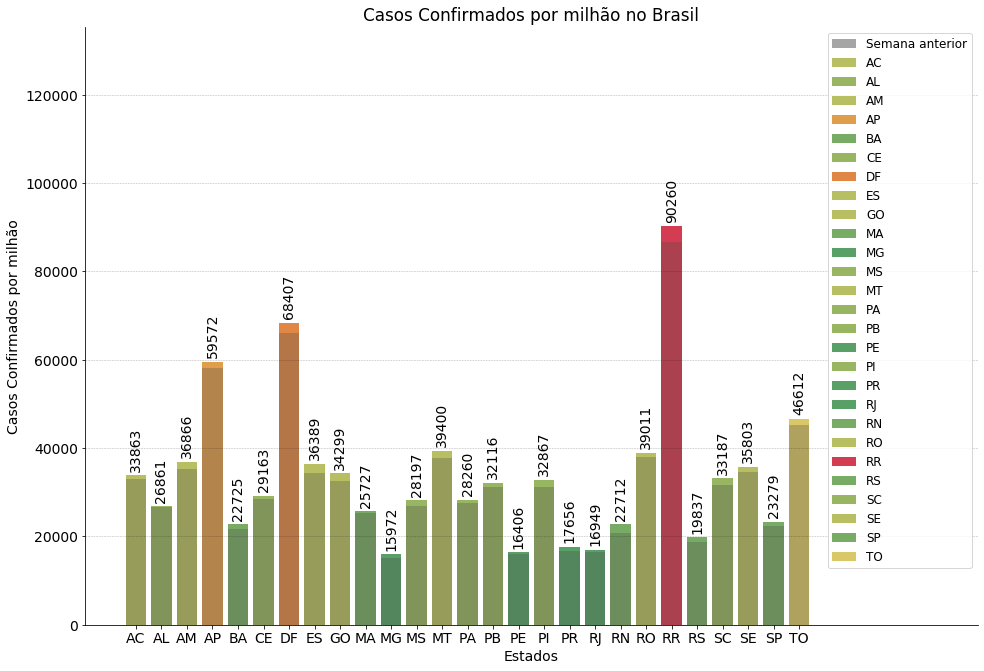

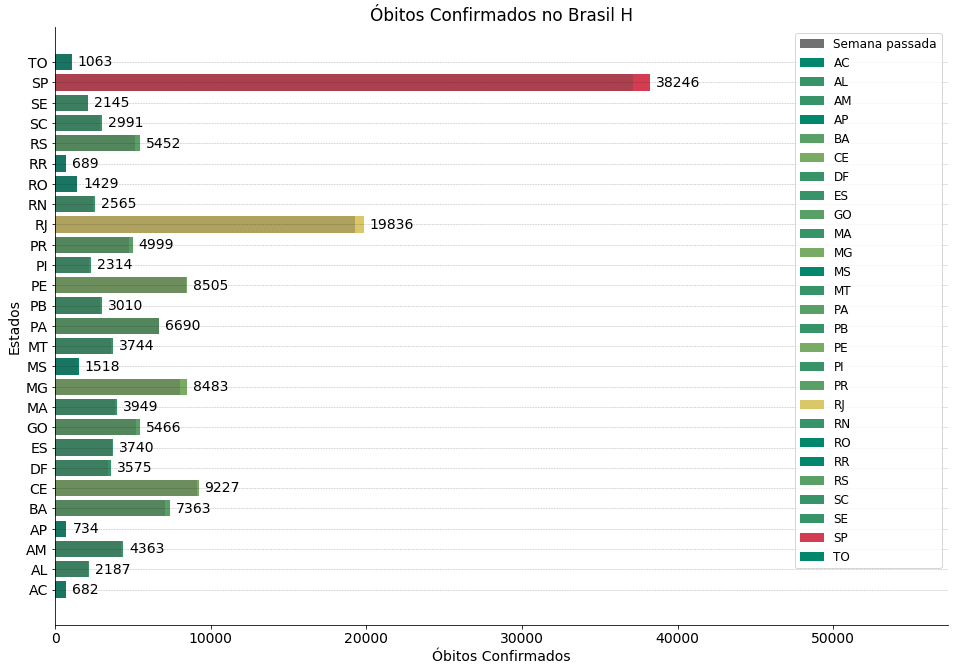

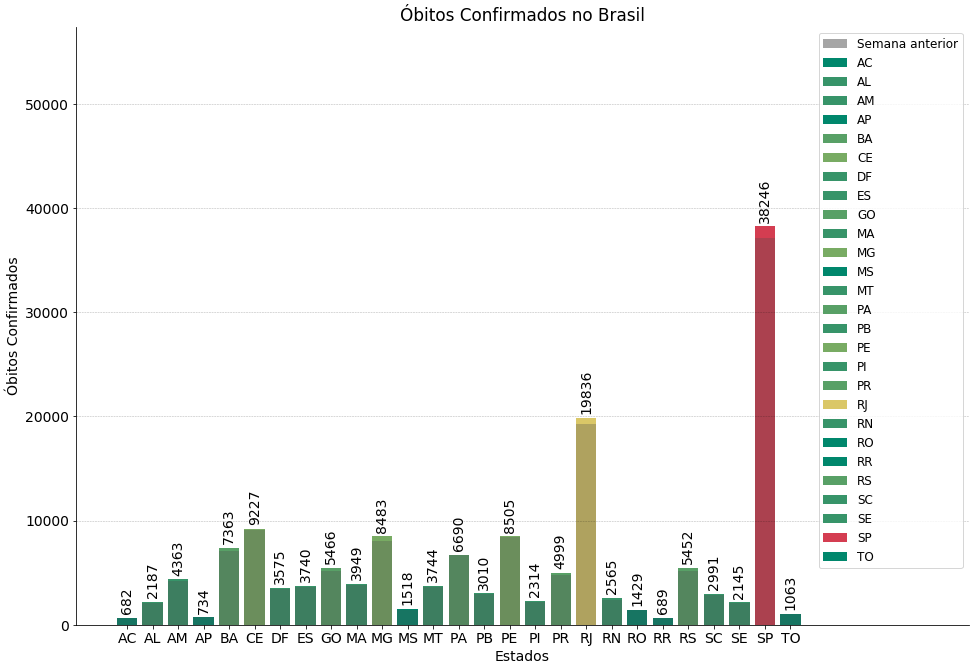

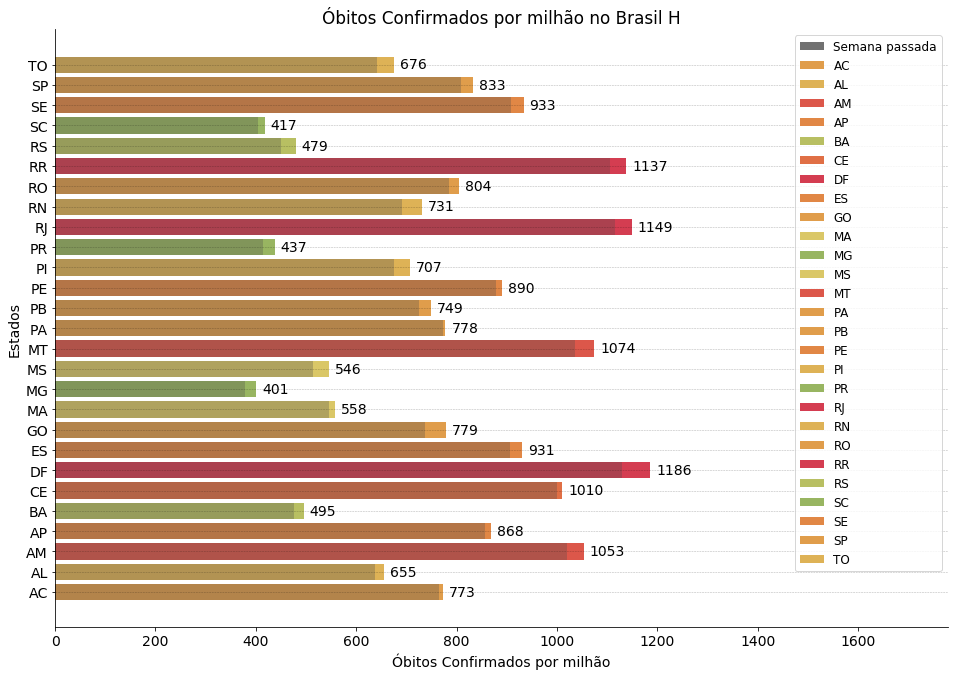

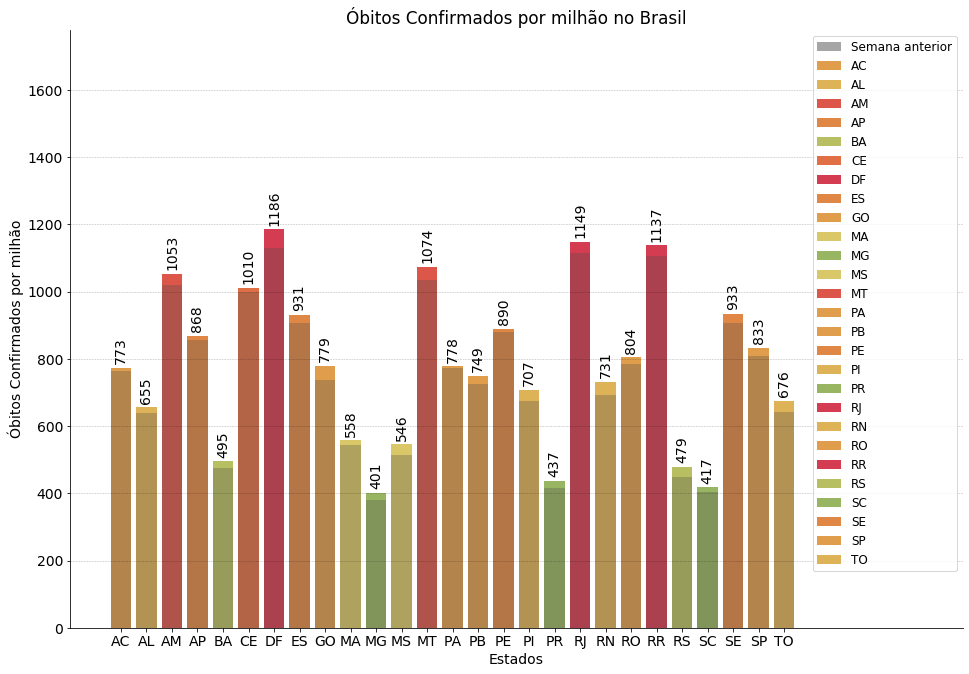

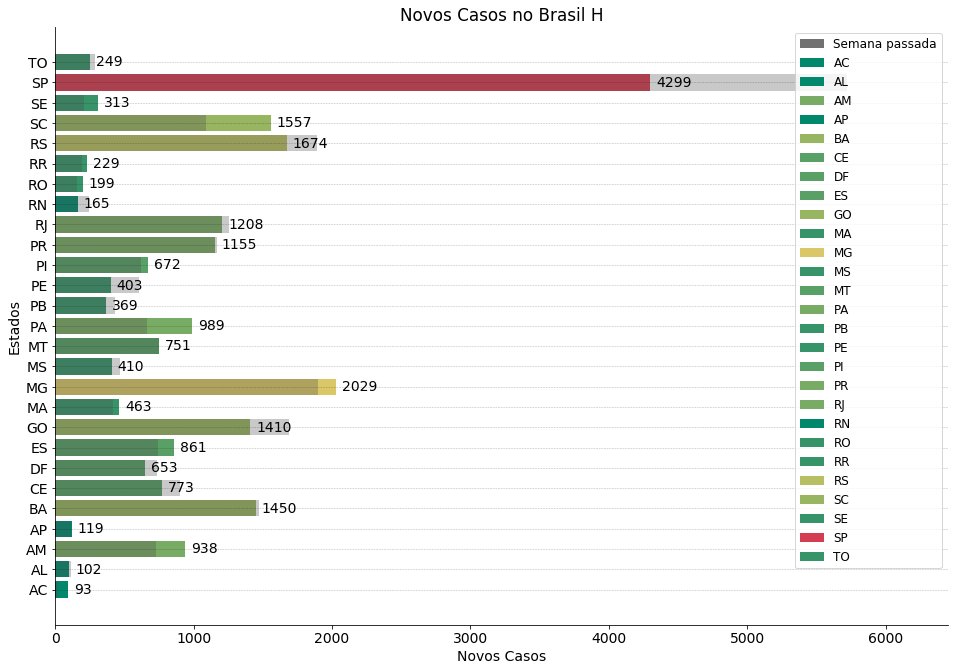

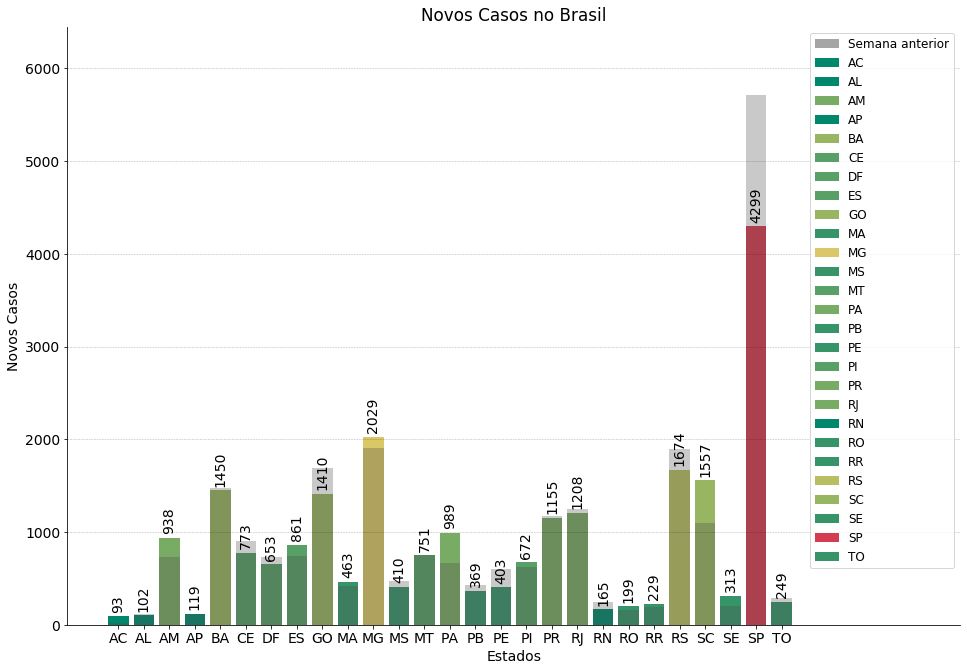

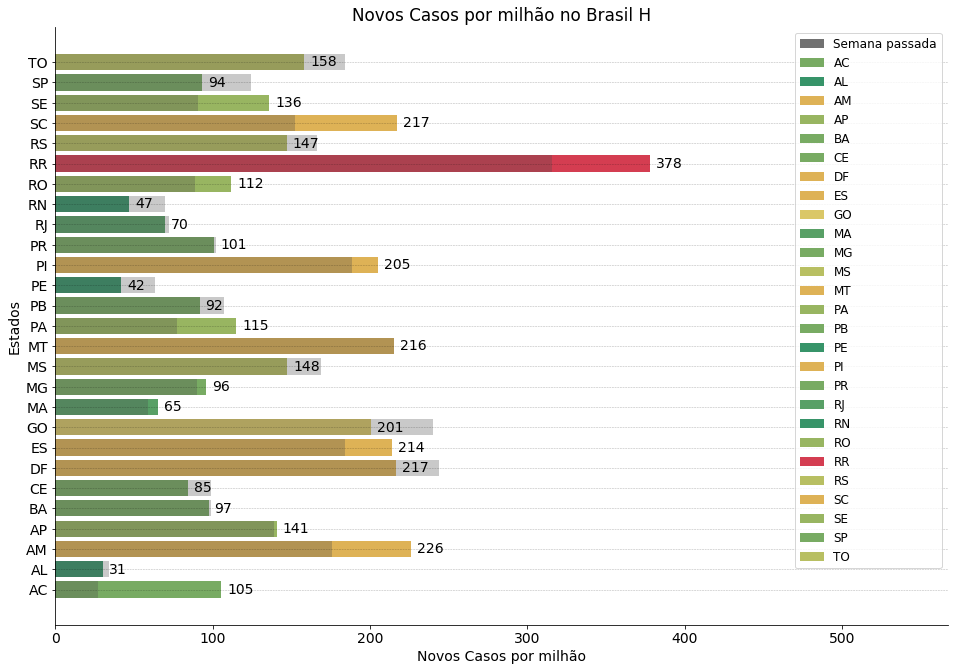

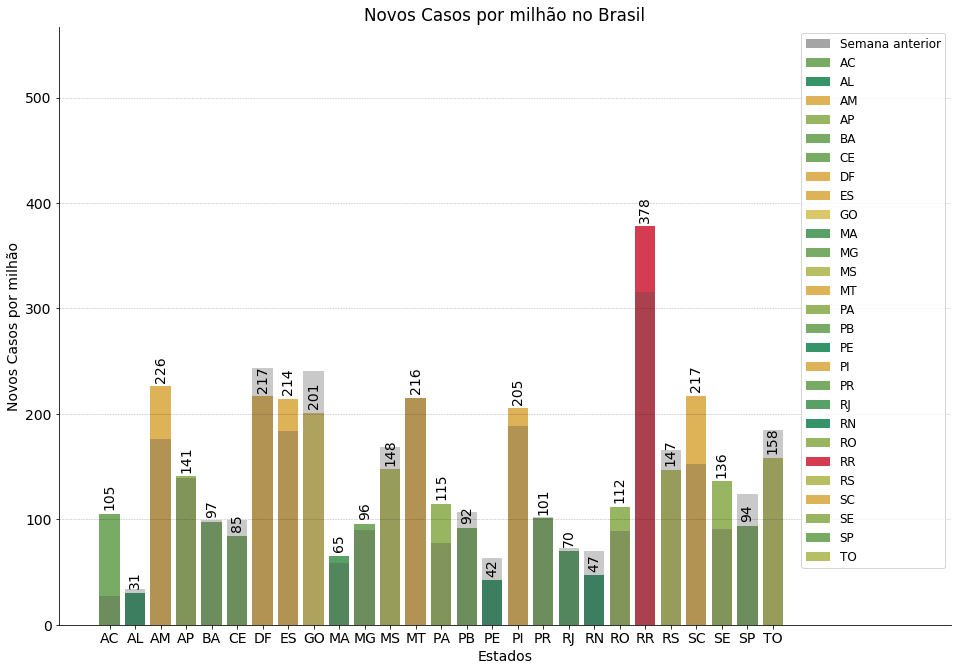

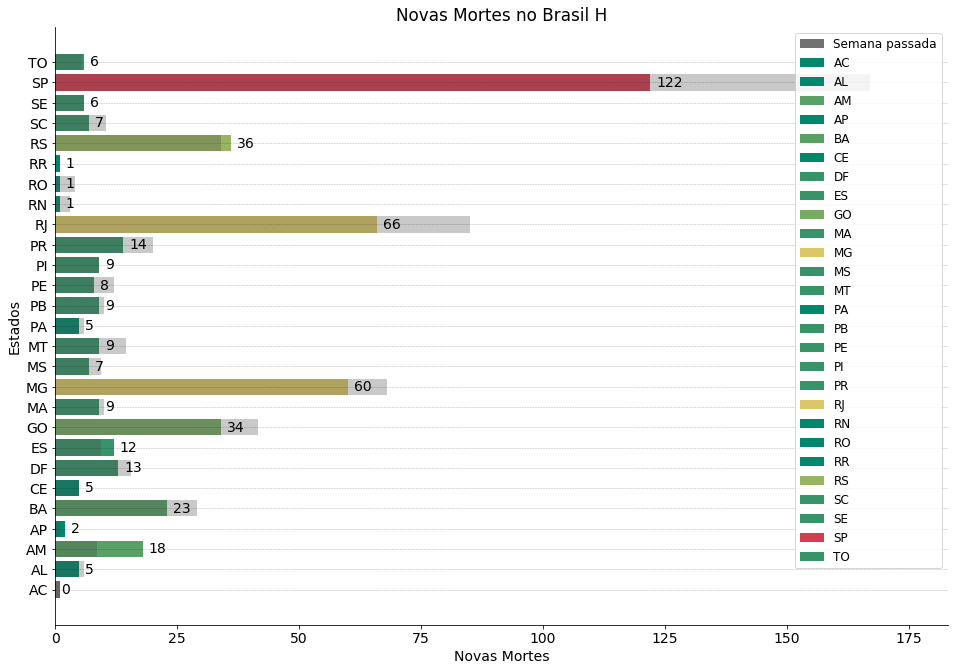

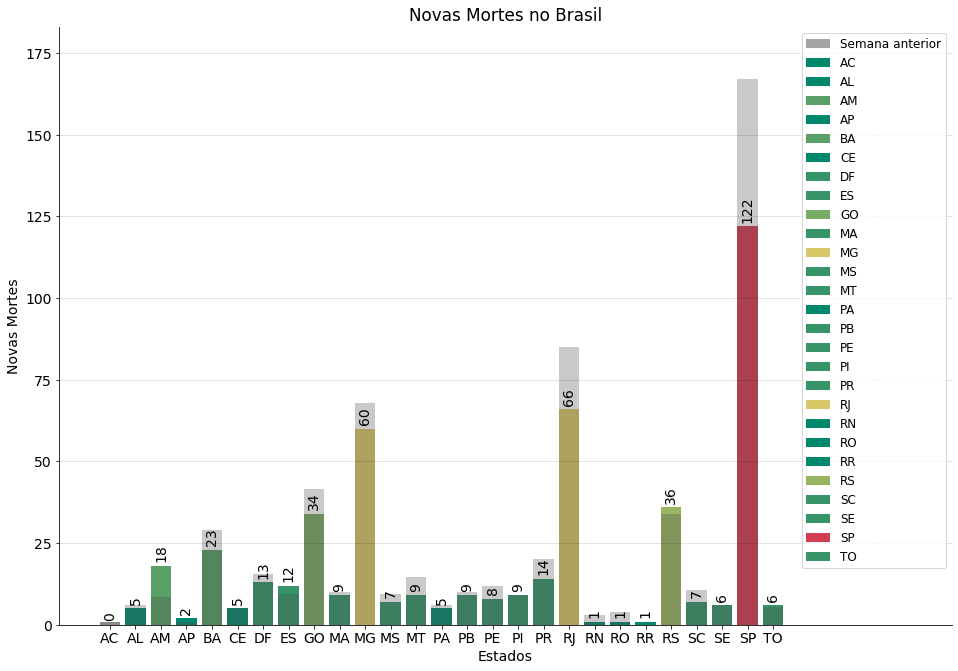

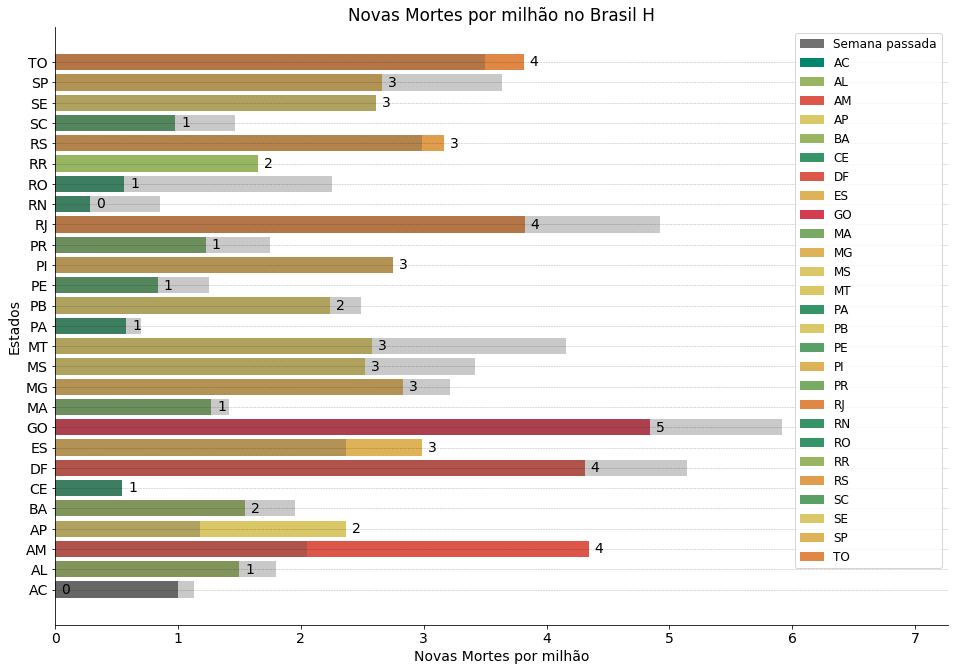

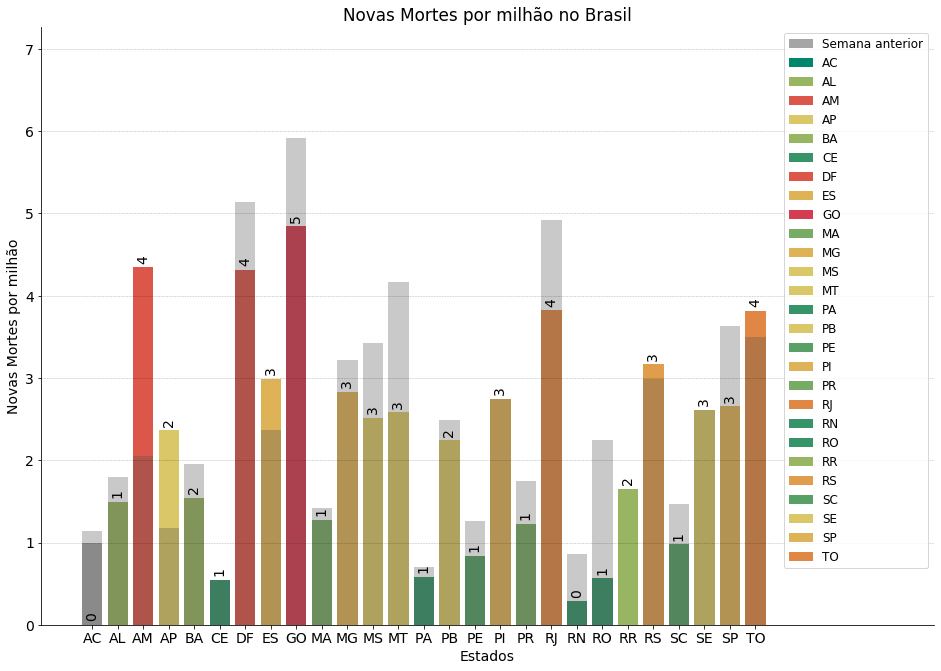

In [25]:
Graficos_gerais_completo(df_estados)

In [26]:
### Aqui tem a variação da semana, colocar depois

# for f in range(7, 11) :  
#     plt.rc('font', size=14)
#     plt.rcParams['figure.figsize'] = [16, 11]

#     plt.gca().spines["top"].set_visible(False)    
#     plt.gca().spines["right"].set_visible(False)
#     plt.gca().get_xaxis().tick_bottom()    
#     plt.gca().get_yaxis().tick_left()
#     plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

#     estados = list(df_estados.loc[df_estados['is_last'],
#                                   ['state']
#                                  ].sort_values('state', ascending = True)['state'].unique())

#     y_max = 0
#     y_pmax = [5000, 1000, 1000, 200]
        
#     plt.bar(estados[0], 1, label = 'Semana passada', color = (.3, .3, .3, .5))
#     plt.bar(estados[0], 1, label = 'Variação na semana', color = (1, 1, 1, 0.1), edgecolor = 'black')
    
#     for e in range(27) :      
#         pop = max(df_estados.loc[(df_estados['state'] == estados[e]) & (df_estados['is_last']), 
#                                  ['population']].loc[:, 'population'])
        
#         y = np.median(df_estados.loc[(df_estados['state'] == estados[e]), 
#                                    :].sort_values('day_count', ascending = True).iloc[:-1, f].tail(7))
        
#         y_pop = (10 ** 6) * y / pop
#         y_pop_std = (10 ** 6) * np.std(df_estados.loc[(df_estados['state'] == estados[e]),
#                                                    :].sort_values('day_count', ascending = True).iloc[:-1, f].tail(7)) / pop        
        
#         y_last = np.median(df_estados.loc[(df_estados['state'] == estados[e]), 
#                                    :].sort_values('day_count', ascending = True).iloc[:-8, f].tail(14))
        
#         y_pop_last = (10 ** 6) * y_last / pop
#         y_pop_last_std = (10 ** 6) * np.std(df_estados.loc[(df_estados['state'] == estados[e]), 
#                                                     :].sort_values('day_count', ascending = True).iloc[:-8, f].tail(14)) / pop
        
#         if (y_pop + y_pop_std) > y_max : y_max = (y_pop + y_pop_std)
#         #print(y_pop_std)
        
#         ratio = y_pop / y_max
#         plt.bar(estados[e], y_pop, yerr = y_pop_std, label = estados[e],
#                 color = color2[int(round(12 * ratio, 0))], align='center', capsize = 6)
        
#         plt.bar(estados[e], y_pop_last, color = (.3, .3, .3, .3))
        
#     plt.xlabel('Estados')       
#     plt.ylim(0, y_max * 1.4)         
#     plt.title(label[f] + " por milhão de habitantes - Brasil")
#     plt.legend(ncol = 6)
#     plt.ylabel(label[f] + " por milhão de habitantes")
#     plt.savefig('Graphics/' + label[f] + " 1M.png")
#     plt.show()

In [27]:
def Mortalidade_contabilizada(data) :
    
    estados = list(data.loc[data['is_last'], ['state']].sort_values('state', ascending = True)['state'].unique())
    
    mortalidade, mortalidade_last = [], []
    
    for e, estado in enumerate(estados) :
            
        casos = np.median(data.loc[(data['state'] == estado), 
                                   :].sort_values('day_count', ascending = True).iloc[:-1, 7].tail(7))

        casos_last = np.median(data.loc[(data['state'] == estado), 
                                        :].sort_values('day_count', ascending = True).iloc[:-8, 7].tail(14))
        
        mortes = np.median(data.loc[(data['state'] == estado), 
                                    :].sort_values('day_count', ascending = True).iloc[:-1, 8].tail(7))

        mortes_last = np.median(data.loc[(data['state'] == estado),
                                         :].sort_values('day_count', ascending = True).iloc[:-8, 8].tail(14))

        mortalidade.append(mortes/casos)
        
        mortalidade_last.append(mortes_last/casos_last)
        
        mort_max = max(mortalidade)
        
    return estados, mortalidade, mortalidade_last, mort_max

In [28]:
def Plot_Mortalidade_contabilizada(modelo, horizontal = False) :
    
    estados = modelo[0]
    y = modelo[1]
    y_last = modelo[2]
    y_max = modelo[3]
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [16, 11]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)

    for e, estado in enumerate(estados) :
        
        ratio = y[e] / y_max
        
        if horizontal :
            if e == 0 :
                plt.barh(estado, 1, label = 'Semana passada', color = (.3, .3, .3, .8))

            plt.barh(estado, 100 * y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.barh(estado, 100 * y_last[e], color = (.3, .3, .3, .3))

            plt.text(100 * y[e] + y_max * 2, estado, str(round(100 * y[e], 1)), color = 'black',  
                     fontsize = 14, horizontalalignment = 'left', verticalalignment = 'center')


        else :
            if e == 0 :
                plt.bar(estado, 1, label = 'Semana anterior', color = (.3, .3, .3, .5))

            plt.bar(estado, 100 * y[e], label = estado, color = color2[int(round(12 * ratio, 0))])

            plt.bar(estado, 100 * y_last[e], color = (.3, .3, .3, .3))

            plt.text(estado, 100 * y[e] + y_max * 2, str(round(y[e] * 100, 1)), color = 'black', rotation = 'vertical',
                     fontsize = 14, horizontalalignment = 'center', verticalalignment = 'bottom')

    if horizontal :
        plt.ylabel('Estados')
        plt.title("Mortalidade por caso no Brasil H")
        plt.xlabel('Porcentagem')
        plt.savefig('Graphics/Mortalidade_por_caso_H.png')

        plt.yticks(range(len(estados)), estados)
        plt.legend(fontsize = 12)
        plt.xlim(0, y_max * 150)
        
    else :
        plt.xlabel('Estados')    
        plt.title("Mortalidade por caso no Brasil")
        plt.ylabel('Porcentagem')
        plt.savefig('Graphics/Mortalidade_por_caso.png')

        plt.legend(fontsize = 12)
        plt.xlim(-2, len(estados) + 6)
        plt.ylim(0, y_max * 150)

    plt.show()

In [29]:
def Graficos_mortalidade(data) :
    modelm = Mortalidade_contabilizada(data)
    Plot_Mortalidade_contabilizada(modelm, True)
    Plot_Mortalidade_contabilizada(modelm, False)

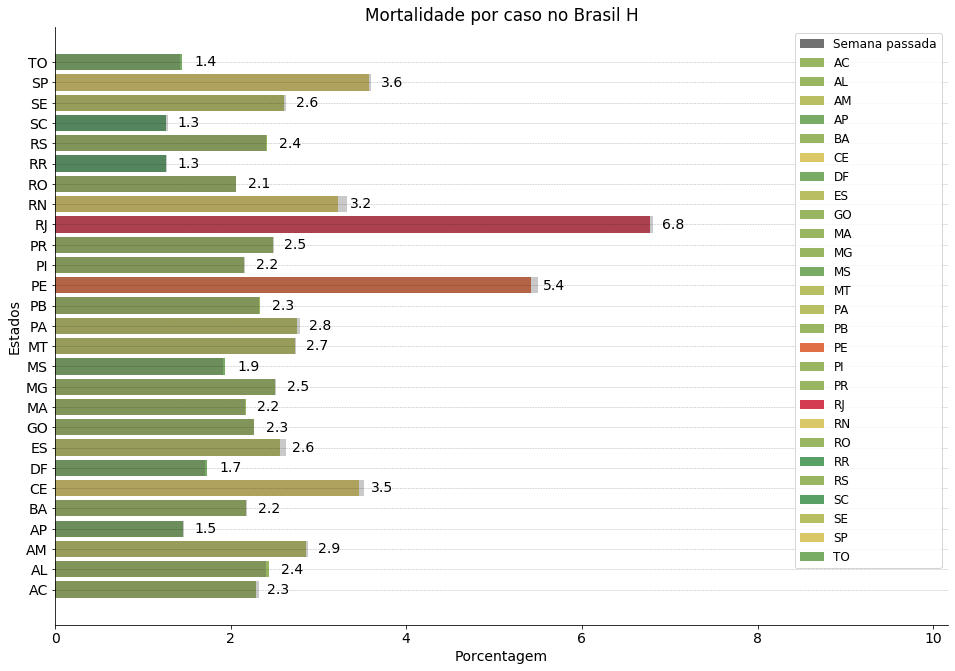

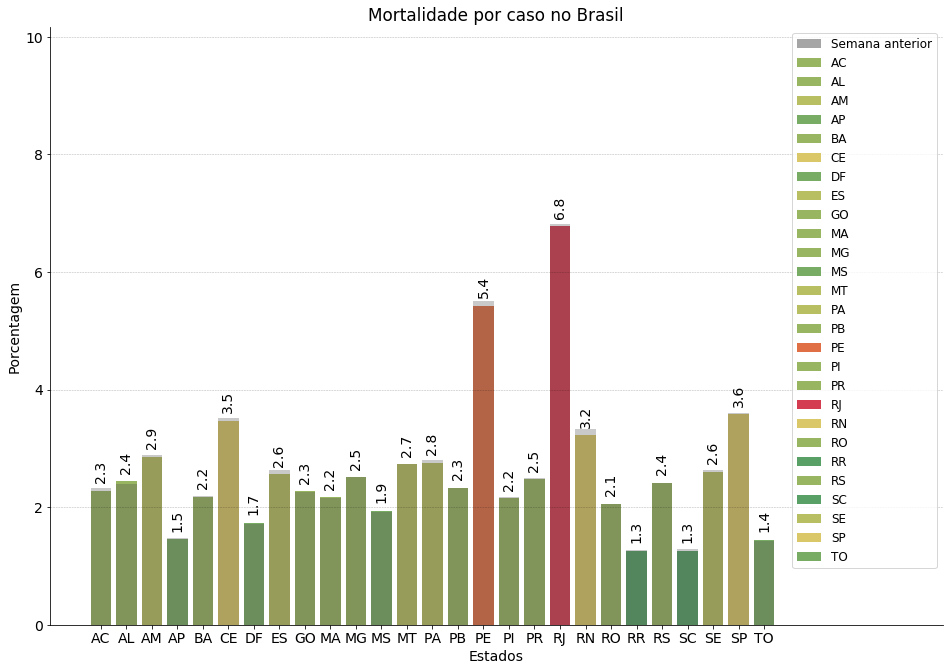

In [30]:
Graficos_mortalidade(df_estados)

In [174]:
def Crescimento(data, dado, periodo = 7, ratio = True) :
    
    estados = list(data.loc[data['is_last'], ['state']].sort_values('state', ascending = True)['state'].unique())
    
    #dado.replace({'casos' : 7, 'mortes' : 8, 'novos_casos' : 9, 'novas_mortes' : 10})
    if dado == 'novas_mortes' :
        dado = 10
    elif dado == 'novos_casos' :
        dado = 9
    elif dado == 'mortes' :
        dado = 8
    else :
        dado = 7

    valor = []
    
    for e, estado in enumerate(estados) :
            
        y = np.median(data.loc[(data['state'] == estado), 
                                   :].sort_values('day_count', ascending = True).iloc[:-1, dado].tail(periodo))

        y_last = np.median(data.loc[(data['state'] == estado), 
                                    :].sort_values('day_count', ascending = True).iloc[:(-1 * periodo - 1), dado].tail(2 * periodo))
        
        if ratio :
            valor.append(100 * ((y / y_last) - 1))
        else :
            valor.append(y - y_last)
        
        if np.isnan(valor[e]) :
            print(valor[e], y, y_last, dado, periodo)
            valor[e] = 0
        if np.isfinite(valor[e]) == False :
            print(valor[e], y, y_last, dado, periodo)
            valor[e] = 0
    valor_max = max(valor)
    valor_min = min(valor)
        
    return estados, dado, ratio, valor, valor_max, valor_min

In [187]:
def Plot_Crescimento(modelo, horizontal = False) :
   
    estados = modelo[0]
    label = modelo[1]
    ratio = modelo[2]
    y = modelo[3]
    y_max = modelo[4]
    y_min = modelo[5]
    
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [16, 11]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    
    size = max([abs(y_min), y_max])
    
    for e, estado in enumerate(estados) :
        
        r = ((y[e] - y_min) / (y_max - y_min))
        
        if horizontal :
            
            plt.barh(estado, y[e], label = estado, color = color2[int(round(12 * r, 0))])

            if y[e] != 0 :   
                if y_min < 0 :
                    plt.text(y[e] + .06 * size * (abs(y[e])/y[e]), estado, str(round(y[e], 1)), color = 'black', 
                             fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
                else :
                    plt.text(y[e] + .06 * size, estado, str(round(y[e], 1)), color = 'black', 
                             fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
                    y_min = 0
            else :
                plt.text(.06 * size, estado, str(round(y[e], 1)), color = 'black', 
                         fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')     
            
        else :

            plt.bar(estado, y[e], label = estado, color = color2[int(round(12 * r, 0))])
            
            if y[e] != 0 :   
                if y_min < 0 :
                    plt.text(estado, y[e] + .06 * size * (abs(y[e])/y[e]), str(round(y[e], 1)), color = 'black', rotation = 'vertical',
                             fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
                else :
                    plt.text(estado, y[e] + .06 * size, str(round(y[e], 1)), color = 'black', rotation = 'vertical',
                             fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')
                    y_min = 0
            else :
                plt.text(estado, .06 * size, str(round(y[e], 1)), color = 'black', rotation = 'vertical',
                         fontsize = 14, horizontalalignment = 'center', verticalalignment = 'center')

    plt.legend(fontsize = 12)
    if horizontal :
        if ratio :
            plt.ylabel('Estados')
            plt.title("Crescimento de " + label_estados[label] + " Relativo no Brasil H")
            plt.xlabel('Porcentagem')
            plt.savefig('Graphics/Crescimento' + label_estados[label] + '_RelH.png')

            plt.yticks(range(len(estados)), estados)
            if y_min < 0 :
                plt.xlim(size * -1.2, size * 1.2)
            else :
                plt.xlim(0, size * 1.2)
        else :
            plt.ylabel('Estados')
            plt.title("Crescimento de " + label_estados[label] + " Absoluto no Brasil H")
            plt.xlabel('Diferença de ' + label_estados[label])
            plt.savefig('Graphics/Crescimento' + label_estados[label] + '_AbsH.png')

            plt.yticks(range(len(estados)), estados)
            if y_min < 0 :
                plt.xlim(size * -1.2, size * 1.2)
            else :
                plt.xlim(0, size * 1.2)

    else :
        if ratio :
            plt.xlabel('Estados')    
            plt.title("Crescimento de " + label_estados[label] + " Relativo no Brasil")
            plt.ylabel('Porcentagem')
            plt.savefig('Graphics/Crescimento' + label_estados[label] + '_Rel.png')

            plt.xlim(-2, len(estados) + 6)
            if y_min < 0 :
                plt.ylim(size * -1.2, size * 1.2)
            else :
                plt.ylim(0, size * 1.2)    
        else :
            plt.xlabel('Estados')    
            plt.title(label_estados[label] + " Absoluto no Brasil")
            plt.ylabel('Diferença de ' + label_estados[label])
            plt.savefig('Graphics/Crescimento' + label_estados[label] + '_Abs.png')

            plt.xlim(-2, len(estados) + 6)
            if y_min < 0 :
                plt.ylim(size * -1.2, size * 1.2)
            else :
                plt.ylim(0, size * 1.2) 

    plt.show()

In [185]:
def Crescimento_completo(data) :
    dados = ['casos', 'mortes', 'novos_casos', 'novas_mortes']
    for dado in dados :
        modelc = Crescimento(data, dado)
        Plot_Crescimento(modelc, True)
        Plot_Crescimento(modelc, False)
        
        modelc = Crescimento(data, dado, 7, False)
        Plot_Crescimento(modelc, True)
        Plot_Crescimento(modelc, False)

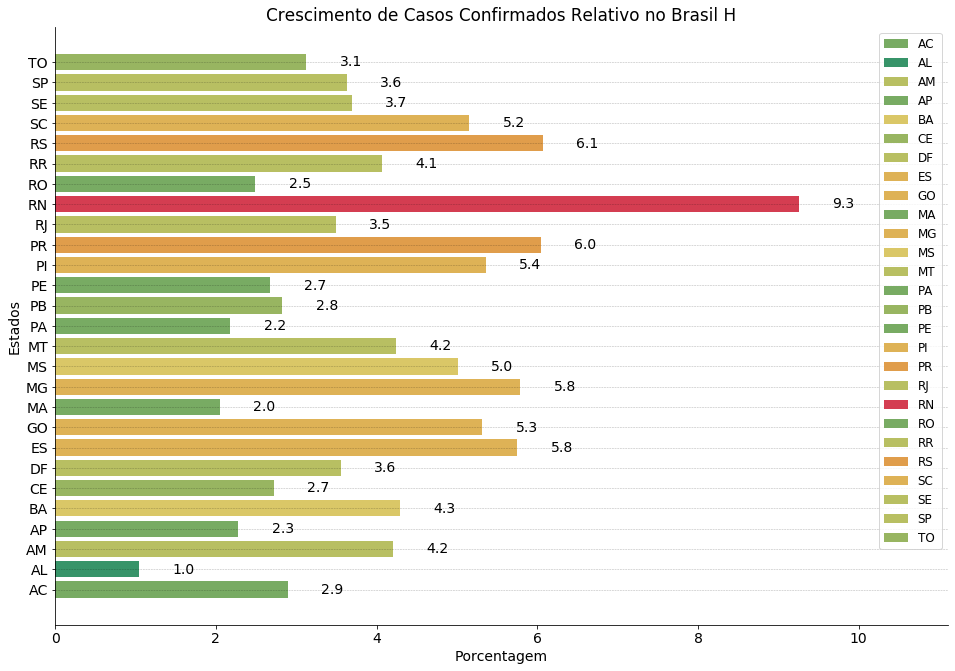

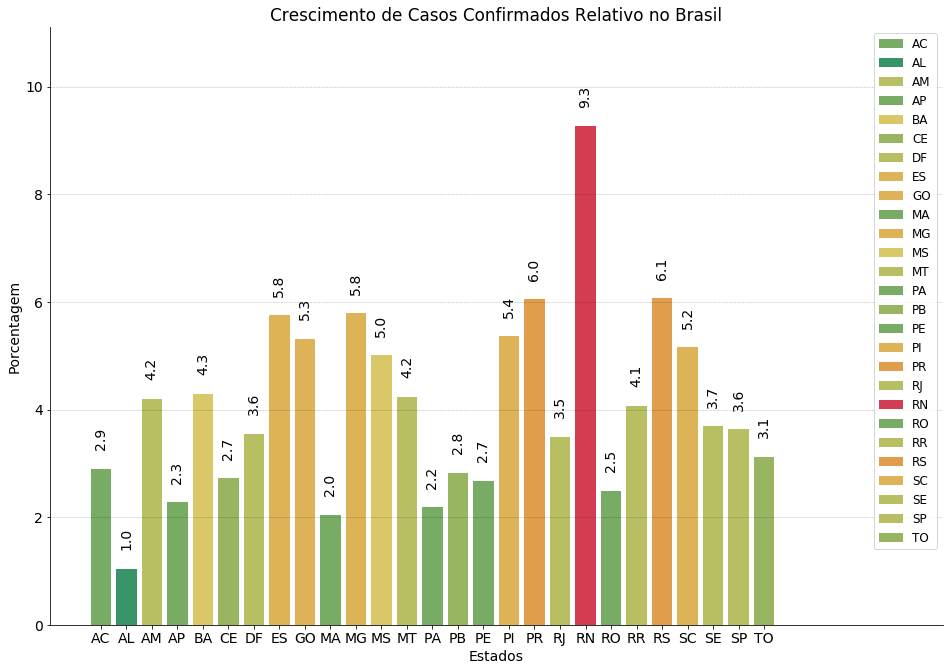

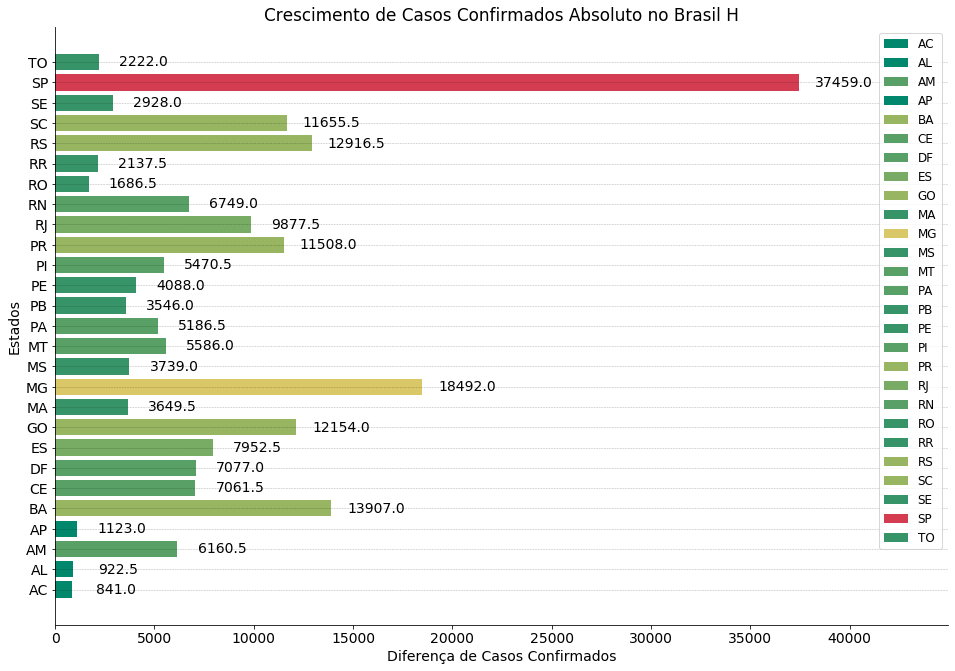

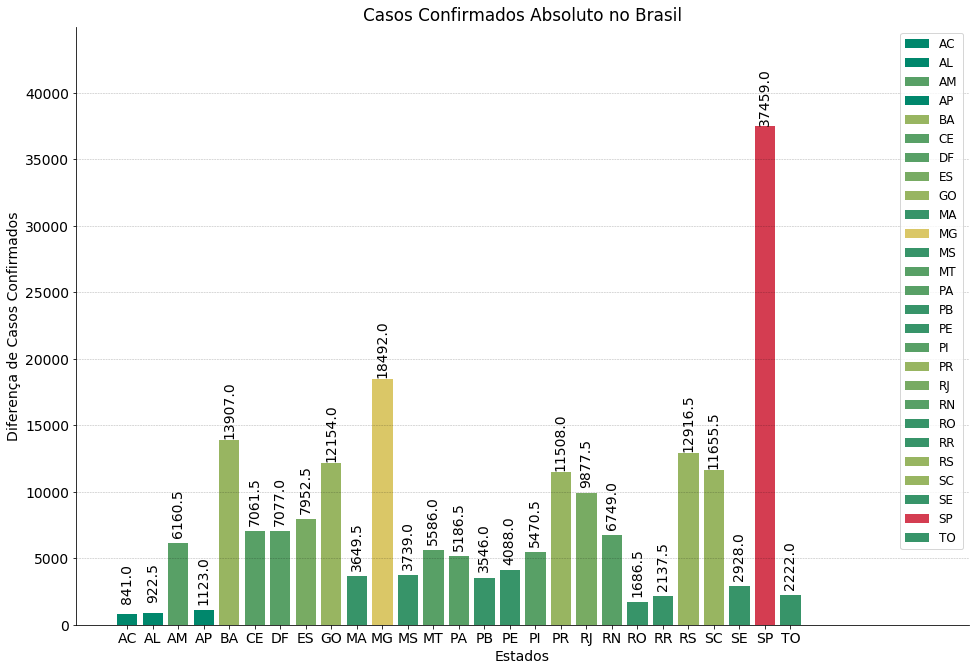

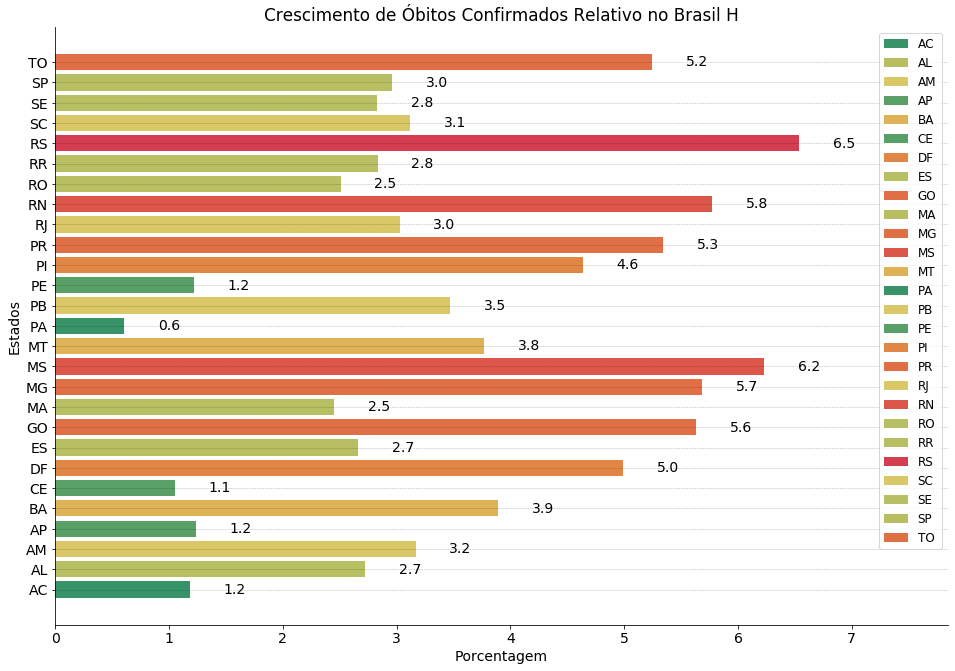

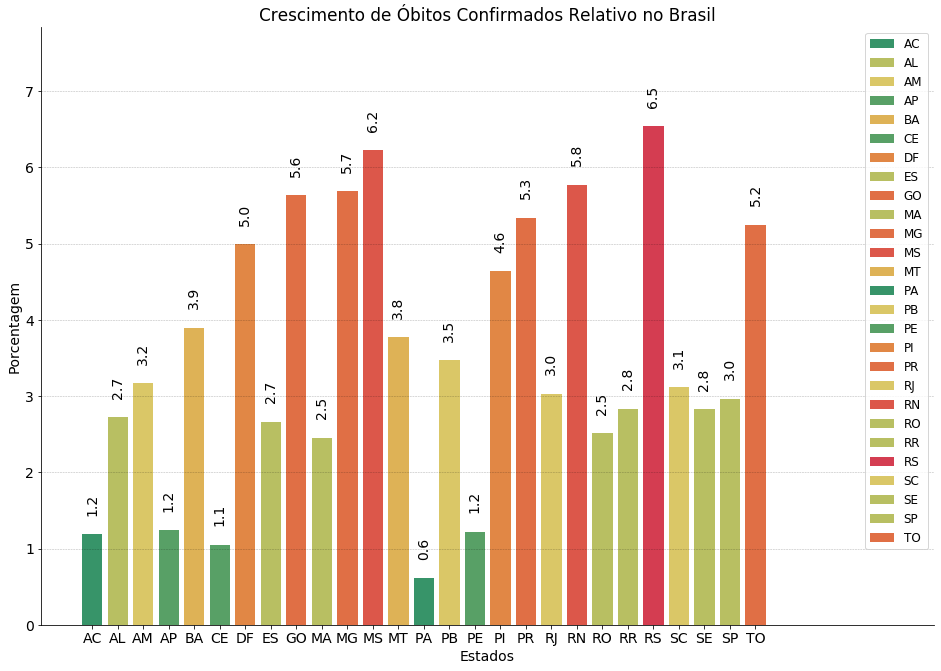

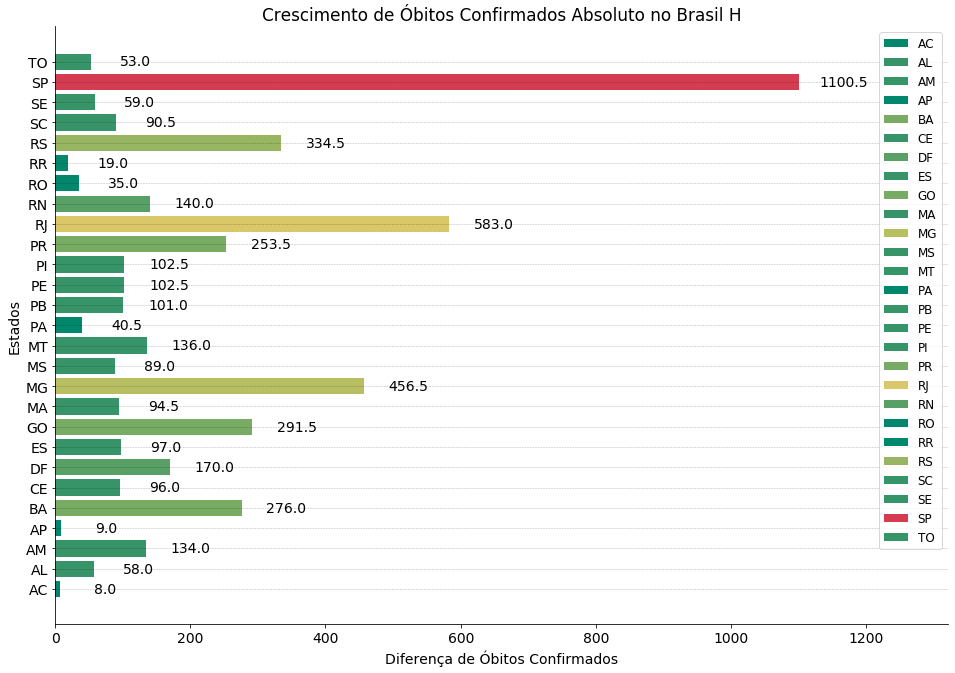

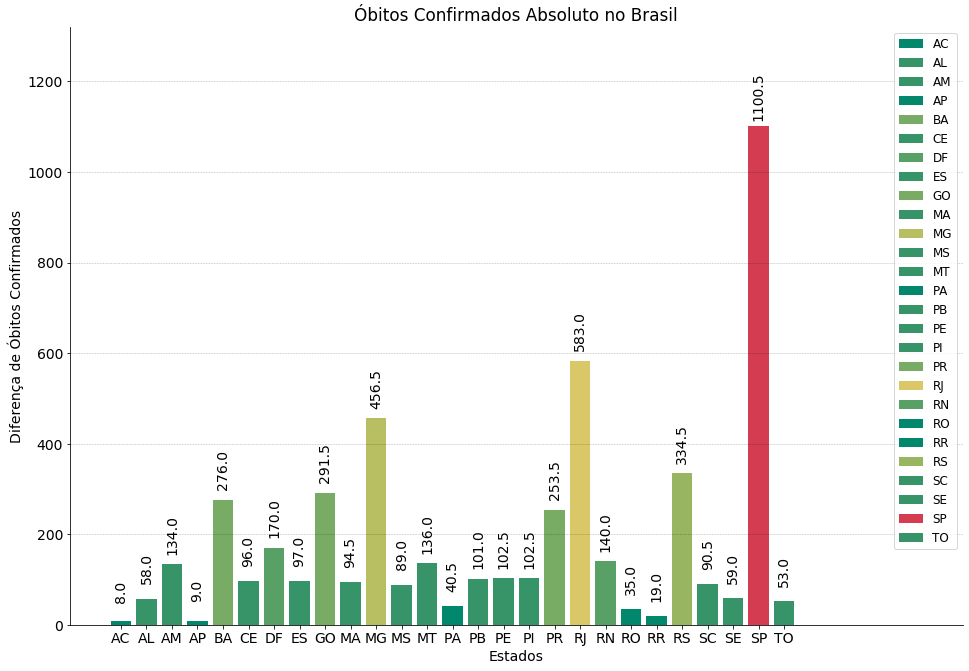

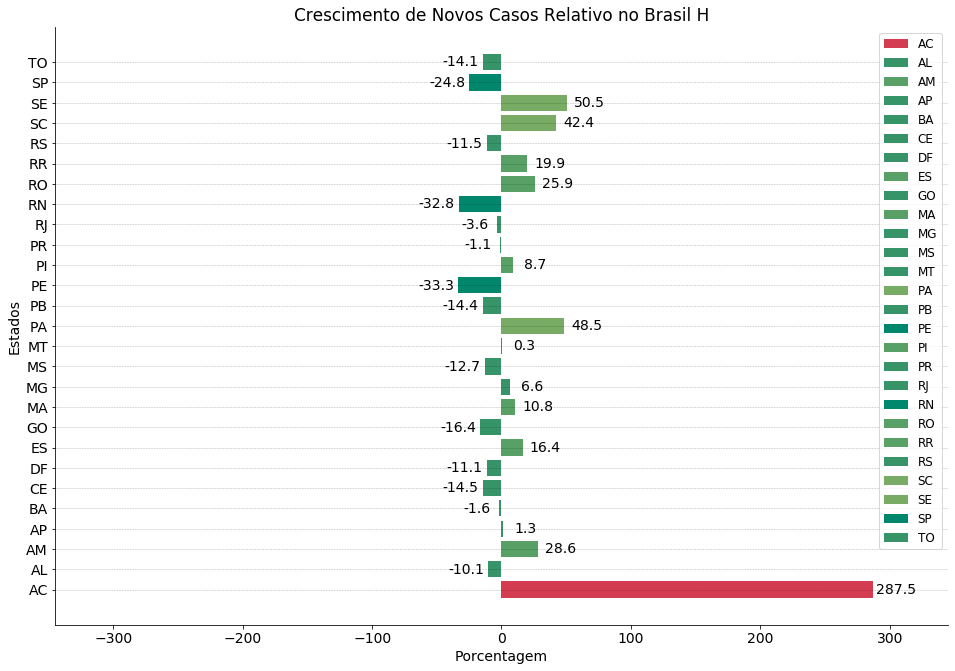

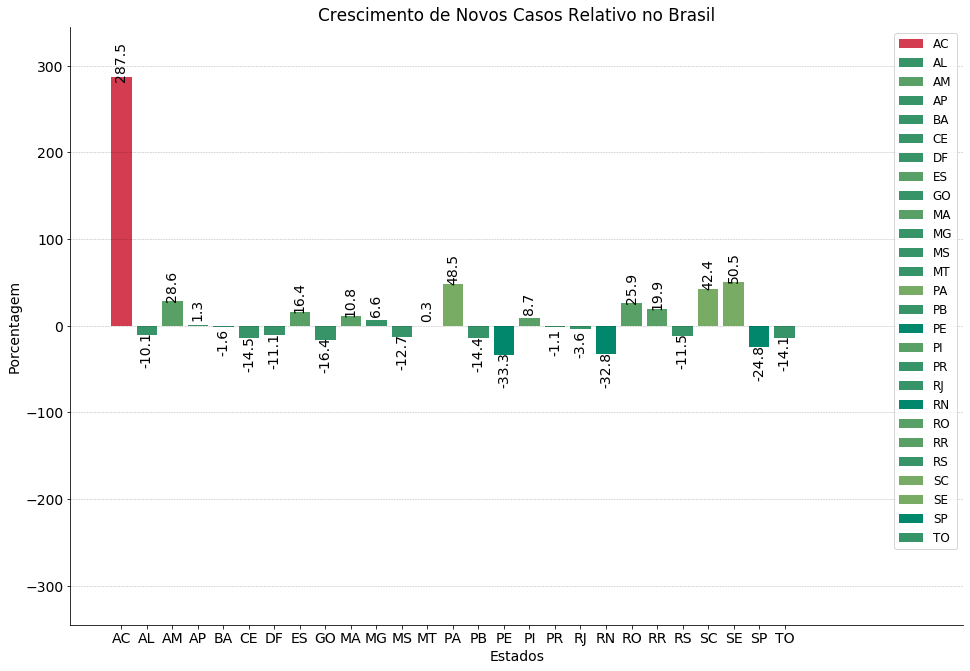

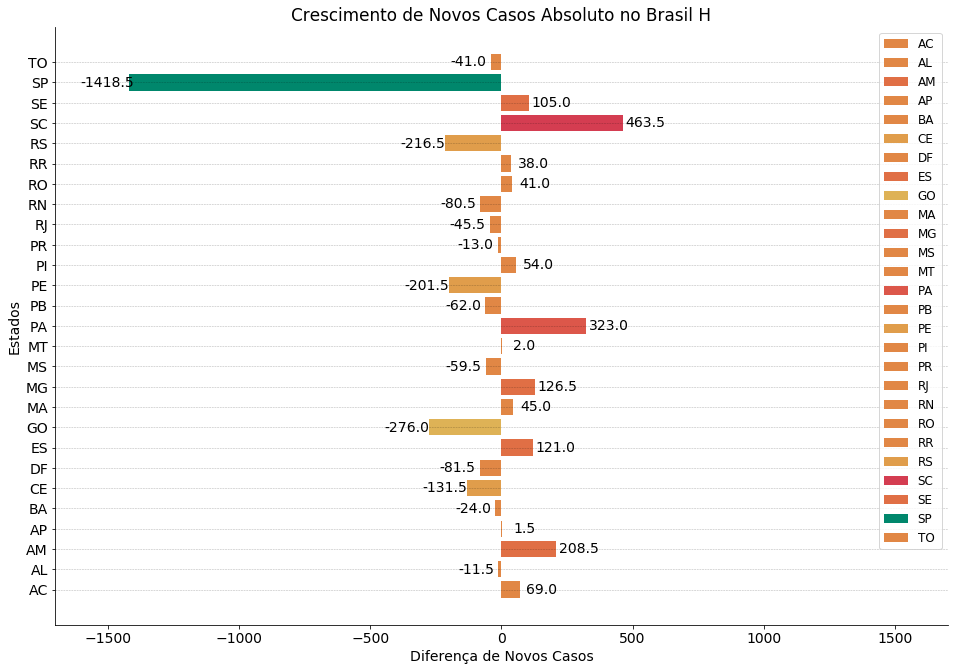

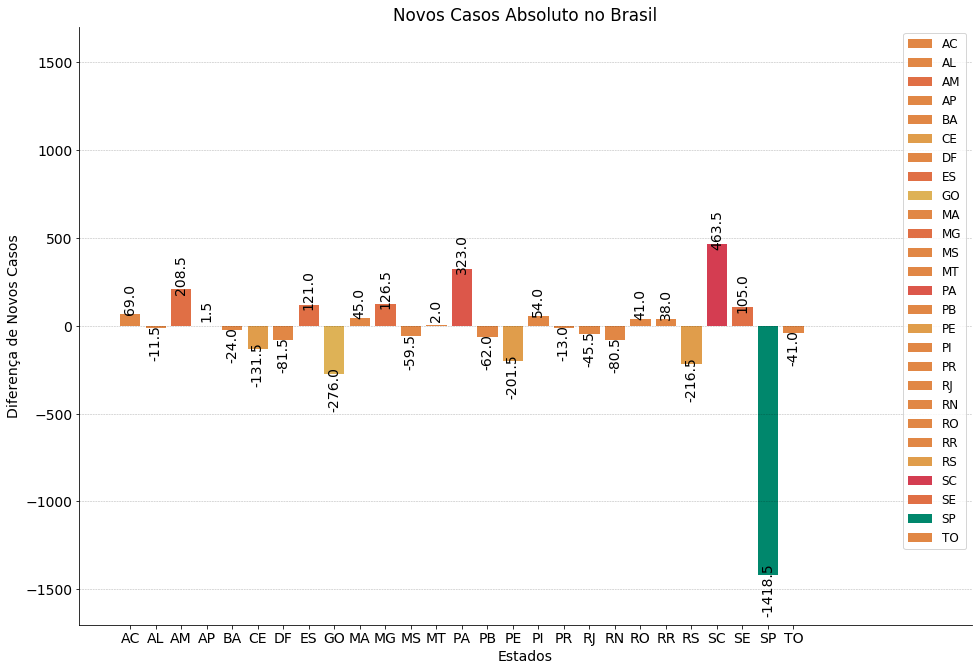

E:\Users\Charles\anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


inf 1.0 0.0 10 7


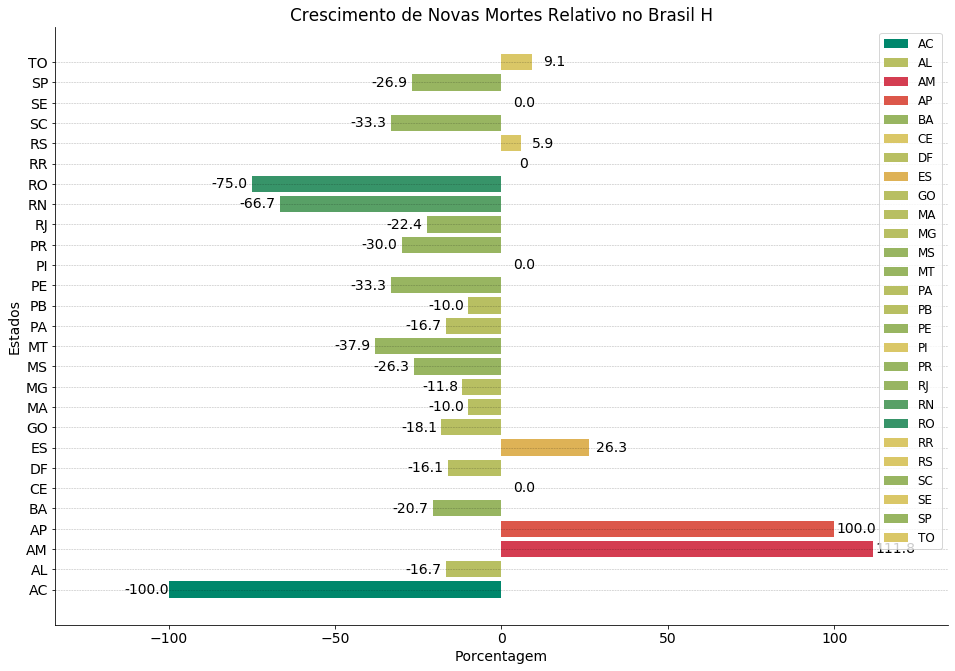

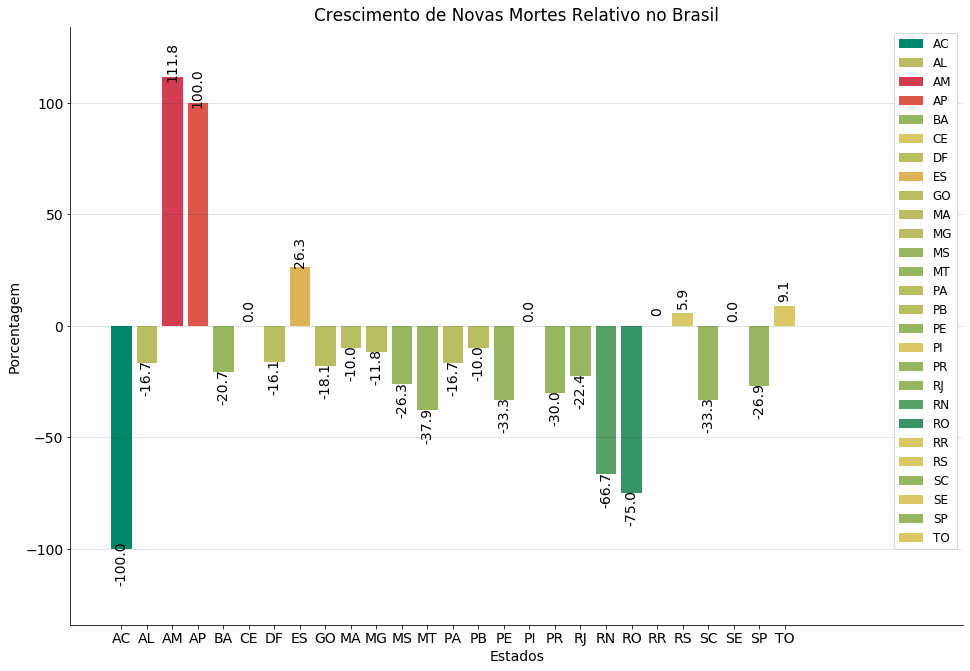

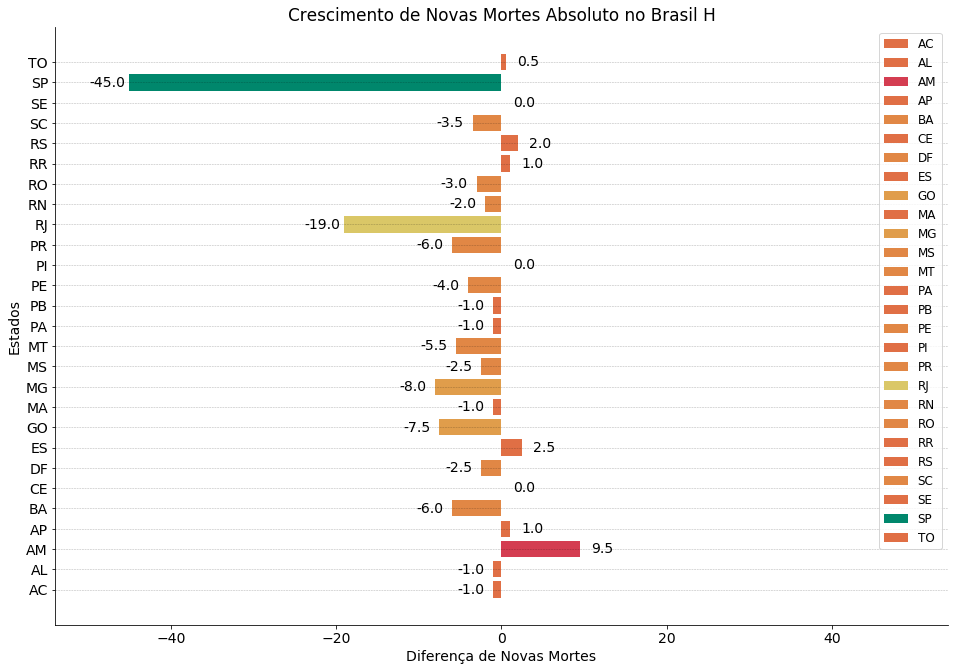

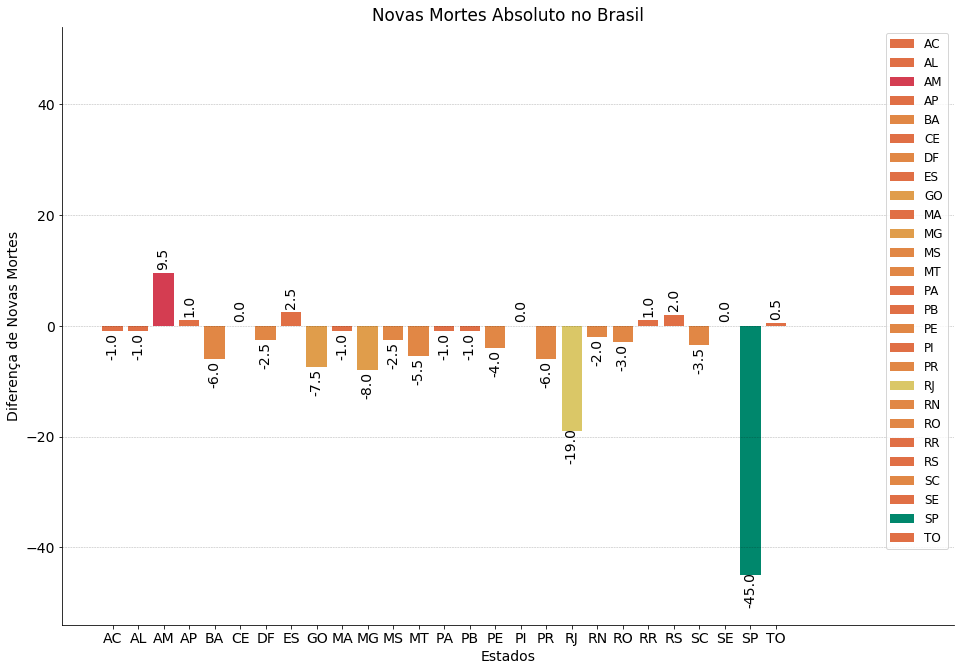

In [188]:
Crescimento_completo(df_estados)

In [ ]:
label = ["Cidade", "Estado", "Região", "População", "Último dado", "Data", "Dia Local", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", 'Dia Brasil' "Incidência de Casos", "Mortalidade"]

In [ ]:
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

for r in range(5) :
    for f in range(7, 9) :     
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [16, 11]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")
        
        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()
        
        dia = max(df_cidades[(df_cidades['region'] == reg[r])].loc[:, 'local_day'])
        
        x_max = dia
        y_max = 0
        
        Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r]) &
                           (df_cidades['is_last'])].sort_values(df_cidades.columns[f],
                                                                ascending = False)['city'].unique())

        y_max = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                    (df_cidades['city'] == Regiao_c[0]), df_cidades.columns[f]])
        y_med = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                    (df_cidades['city'] == Regiao_c[1]), df_cidades.columns[f]])
        y_min = max(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                    (df_cidades['city'] == Regiao_c[5]), df_cidades.columns[f]])

        for c in range(len(Regiao_c)) : 
            # Real data
            x = list(df_cidades.loc[(df_cidades['region'] == reg[r]) & 
                                    (df_cidades['city'] == Regiao_c[c]), 'local_day'])
            y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                    (df_cidades['city'] == Regiao_c[c]), df_cidades.columns[f]])

            if (c > 5) & (c < 50) :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
            elif c == 5 :
                plt.plot(x, y, marker = ' ', label = 'Outros municípios', color = (.5, .5, .5, .3), lw = 1.5)
            elif (c >= 2) & (c < 5) :
                plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                ys = y_min + (y_med - y_min) / c
                #plt.text(x_max * 1.01, ys, Regiao_c[c], color = color[c], fontsize = 14)
            elif (c < 2):
                plt.plot(x, y, marker = ' ', label = Regiao_c[c], color = color[c], lw = 2.5)
                #plt.text(x_max * 1.01, y[-1] * 1.01, Regiao_c[c], color = color[c], fontsize = 14)
                

        plt.xlim(1, x_max + 1)
        plt.ylim(0, y_max * 1.03)
        plt.xlabel("Dias após o primeiro caso confirmado")
        plt.title(label[f] + " na Regiao " + reg[r])
        plt.legend(loc = 2)
        plt.ylabel(label[f])
        plt.savefig('Graphics/' + label[f] + " - " + reg[r] + ".png")
        plt.show()

In [ ]:
label = ["Cidade", "Estado", "Região", "População", "Último dado", "Data", "dia", "Casos Confirmados", 
           "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

dia = len(df_Brasil.index)

for r in range(5) :
    for f in range(9, 11) :          
        plt.rc('font', size = 14)
        plt.rcParams['figure.figsize'] = [14, 10]
        plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                        labelbottom = "on", left = "off", right = "off", labelleft = "on")
        
        plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
        plt.gca().spines["top"].set_visible(False)    
        plt.gca().spines["right"].set_visible(False)
        plt.gca().get_xaxis().tick_bottom()    
        plt.gca().get_yaxis().tick_left()

        Regiao_c = list(df_cidades[(df_cidades['region'] == reg[r]) & (df_cidades['is_last'])
                                  ].sort_values(df_cidades.columns[f], ascending = True)['city'].unique())

        first = len(Regiao_c) - 18
      
        x_min = dia
        
        for a in range(first, len(Regiao_c)) :
            temp = len(list(df_cidades.loc[(df_cidades['region'] == reg[r]) & (df_cidades['city'] == Regiao_c[a]), 
                                       df_cidades.columns[f]]))
            if temp < x_min :
                x_min = temp
            if x_min > 46 :
                x_min = 46

        x_max = dia + 1
        y_max = 0

        x = list(range(dia - x_min, dia))
        
        prev = list(df_cidades.loc[(df_cidades['region'] == reg[r]) &
                                   (df_cidades['city'] == Regiao_c[first]), 
                                   df_cidades.columns[f]].tail(x_min).reset_index(drop = True))

        for c in range(first, len(Regiao_c)) : 
            if c == first :
                plt.bar(x, prev, label = 'Outros Municípios', color = (.5, .5, .5, .3))
                yfirst = prev
                
            y = list(df_cidades.loc[(df_cidades['region'] == reg[r]) & (df_cidades['city'] == Regiao_c[c]),
                                    df_cidades.columns[f]].tail(x_min).reset_index(drop = True))                  
                
            if c == len(Regiao_c) - len(color3):    
                plt.bar(x, prev, bottom = yfirst, color = (.5, .5, .5, .3))
            if c >= len(Regiao_c) - len(color3):
                plt.bar(x, y, bottom = prev, label = Regiao_c[c], color = color3[c - len(Regiao_c)])
                
                
            
            prev = [sum(i) for i in zip(y, prev)]

            if max(prev) > y_max :
                y_max = max(prev)
                
        for i, v in enumerate(prev):
            plt.text(i + (dia - x_min), v + (y_max * 0.01), str(v), color = color3[c - len(Regiao_c)],
                     fontsize = 9, fontweight = 'bold', horizontalalignment = 'center')
        
        plt.xticks(np.arange(dia - x_min - 7, x_max, 3))
        ytick = round(y_max * .001) * 100
        
        if ytick == 0 :
            ytick = round(y_max * .01) * 10
            if ytick == 0 :
                ytick = 1
            
        plt.yticks(np.arange(0, y_max * 1.1, ytick))   

        plt.xlim(dia - x_min - 7, x_max)
        plt.title(label[f] + " na Regiao " + reg[r])
        plt.xlabel("Dias após 25/02/2020")
        plt.legend()
        plt.ylabel(label[f])
        plt.savefig('Graphics/' + label[f] + " - " + reg[r] + ".png")
        plt.show()

df_hoje = df1.loc[(df["is_last"] == True), :].drop(['date', 'is_last'], axis = 1)
df_hoje = df_hoje.loc[(df_hoje["place_type"] == 'city'), :]
df_hoje = df_hoje.loc[(df_hoje["city"] != 'Importados/Indefinidos'), :]
df_hoje['city_ibge_code'] = df_hoje['city_ibge_code'].astype(int).astype(str)

m = folium.Map(
    name = 'COVID19 Brasil',
    width = 800, height = 500,
    location = [-15.77972, -47.92972], #[-7, -36.75], # centro paraiba 
    zoom_start = 4,
    min_zoom = 3,
    max_zoom = 18,
    tiles = 'Mapbox Bright'#'cartodbpositron'
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'confirmed'],
    key_on = 'feature.properties.id',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados',
    legend_fontsize = '14',
    bins = [0, 10, 100, 1000, 10000, 100000]
)

m.choropleth(
    geo_data = geo,
    name = 'Óbitos Confirmados',
    data = df_hoje,
    columns = ['city_ibge_code', 'deaths'],
    key_on = 'feature.properties.id',
    fill_color = 'Reds',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Óbitos Confirmados',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 10000],
    show = False
)

m.choropleth(
    geo_data = geo,
    name = 'Casos Confirmados por 100 mil habitantes',
    data = df_hoje,
    columns = ['city_ibge_code', 'incidence'],
    key_on = 'feature.properties.id',
    fill_color = 'PuRd',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Casos Confirmados por 100 mil habitantes',
    legend_fontsize = '14',
    bins = [0, 1, 10, 100, 1000, 2000],
    show = False
)

bins = list(df_hoje['death_rate'].quantile([0, .125, .25, .375, .5, .625, .75, .875, 1]))
m.choropleth(
    geo_data = geo,
    name = 'Mortalidade',
    data = df_hoje,
    columns = ['city_ibge_code', 'death_rate'],
    key_on = 'feature.properties.id',
    fill_color = 'RdPu',
    fill_opacity = 0.7,
    nan_fill_color = 'gray',
    nan_fill_opacity = 0.1,
    line_opacity = 0.0,
    legend_name = 'Mortalidade',
    legend_fontsize = '14',
    bins = bins,
    show = False
)
folium.LayerControl(name = 'COVID19 Brasil').add_to(m)

m.save('mapa.html')
m

In [ ]:
label = ["Estado", "Região", "População", "Último Dado", 'Data', "Dia", "Casos Confirmados", "Óbitos Confirmados",
         "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]
reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']

for f in range(6, 10) :
    
    dia = max(df_estados.loc[:, 'day'])
    x_max = dia
    
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 10]
    plt.tick_params(axis = "both", which = "both", bottom = "off", top = "off",    
                    labelbottom = "on", left = "off", right = "off", labelleft = "on")

    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left() 

    if f in [6, 7] :
        
        estados = list(df_estados.loc[df_estados['is_last'],
                                      ['state', df_estados.columns[f]]
                                     ].sort_values(df_estados.columns[f], ascending = False)['state'].unique())

        y_max = 0
        
        for e in range(27) :
            # Real data
            x = list(df_estados.loc[df_estados['state'] == estados[e], 'day'])
            y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]])

            y_max = max(df_estados.loc[df_estados['state'] == estados[0], df_estados.columns[f]])
            y_med = max(df_estados.loc[df_estados['state'] == estados[1], df_estados.columns[f]])
            y_min = max(df_estados.loc[df_estados['state'] == estados[5], df_estados.columns[f]])

            if (e > 5) :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .3), lw = 1.5)
            elif e == 5 :
                plt.plot(x, y, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
            elif (e >= 2) & (e < 5) :
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
                ys = y_min + (y_med - y_min) / e
                #plt.text(x_max * 1.01, ys, estados[e], color = color[e], fontsize = 14)
            elif (e < 2):
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
                #plt.text(x_max * 1.01, y[-1] * 1.01, estados[e], color = color[e], fontsize = 14)
            
            plt.xticks(np.arange(x_max - 90, x_max, 5))
            plt.xlim(x_max - 90, x_max + 1)
            plt.ylim(1, y_max * 1.1)
            plt.legend(loc = 2)
    else :   
        estados = list(df_estados.loc[df_estados['is_last'],
                                      ['state', df_estados.columns[f]]
                                     ].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = len(df_Brasil.index)
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        x = list(range(dia - 90, len(df_Brasil.index)))
        y = list(df_estados.loc[df_estados['state'] == estados[0],
                                df_estados.columns[f]].tail(90).reset_index(drop = True))

        prev = y

        for e in range(1, 27) : 
            y = list(df_estados.loc[df_estados['state'] == estados[e], 
                                    df_estados.columns[f]].tail(90).reset_index(drop = True))               

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    if e == 14 :
                        plt.bar(x, prev, label = 'Outros estados', color = (.5, .5, .5, .3))
                    if e > 13 :  
                        plt.bar(x, y, bottom = prev, label = estados[e], color = color2[e - 14])
            prev = [sum(i) for i in zip(y, prev)]
        
        for i, v in enumerate(prev):
            if i > 1 :
                plt.text(i + dia - 89.85, v + (y_max * 0.05), str(v), color = color2[-1], rotation = 'vertical', 
                         fontsize = 8, fontweight = 'bold', horizontalalignment = 'center', verticalalignment = 'center')
        
        plt.xticks(np.arange(x_max - 90, x_max, 5))
        plt.xlim(x_max - 90, x_max + 1)
        plt.ylim(1, y_max * 1.1) 
        plt.legend(loc = 2, columns= 7)
        
        
    plt.title(label[f] + " no Brasil")   
    #plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil.png")
    plt.show()

In [ ]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 10) :
        
    plt.rc('font', size=14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    
    if f in [6, 7] :
        dia = max(df_estados.loc[:, 'day'])
        
        reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']
        estados = list(df_estados.loc[df_estados['is_last'],
                                      [df_estados.columns[f], 'state']
                                     ].sort_values(df_estados.columns[f], ascending = True)['state'].unique())
        
        x_max = dia
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        # Brasil data
        x = range(25, len(df_Brasil.index))
        y = list(df_estados.loc[df_estados['state'] == estados[0], 
                                df_estados.columns[f]
                               ].tail(dia - 25).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.plot(range(5), range(5), label = reg[r], color = color[r], lw = 2.5)
            if estados[0] in Regiao[r] :
                plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)     
        temp = list(df_estados.loc[df_estados['state'] == estados[0], 
                                   df_estados.columns[f]
                                  ].tail(dia - 25).reset_index(drop = True))

        for e in range(1, 27) :                  
            tempa = temp
            tempb = list(df_estados.loc[df_estados['state'] == estados[e], 
                                        df_estados.columns[f]
                                       ].tail(dia - 25).reset_index(drop = True))               
            y = [sum(i) for i in zip(temp, tempb)]
            temp = y

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.plot(x, y, marker = ' ', color = color[r], lw = 2.5)
                    if e > 17 :
                        plt.text(max(x) * 1.01, (max(temp) + max(tempa)) * 0.5, estados[e], color = color[r], fontsize = 14, 
                                 horizontalalignment = 'center', verticalalignment = 'center')
                    plt.fill_between(x, temp, tempa, color = (color[r] + '40'))

        # Brasil data
        x = range(len(df_Brasil.index))
        y = list(df_Brasil.iloc[x, f - 6])
        plt.plot(x, y, color = 'black', label = "Brasil", lw = 1.5) 
#         plt.text(max(x) * 1.01, y[-1] * 1.03, "Brasil", color = "black", fontsize = 14,
#                  horizontalalignment = 'center', verticalalignment = 'center')               

        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)
    
    else :
        dia = len(df_Brasil.index)
        
        df_estados['region'] = 'null'
        reg = ['B Nordeste', 'C Norte', 'A Sudeste', 'D Sul', 'E Centro Oeste']
        for r in range(len(Regiao)) :
            for a in range(len(Regiao[r])) :
                df_estados.loc[df_estados['state'].eq(Regiao[r][a]), 'region'] = reg[r]
        
        estados = list(df_estados.loc[df_estados['is_last'],
                                      ['state', 'region']
                                     ].sort_values('region', ascending = False)['state'].unique())
        
        x_max = len(df_Brasil.index)
        y_max = max(df_Brasil.iloc[range(len(df_Brasil.index)), f - 6])
        
        x = list(range(25, len(df_Brasil.index)))
        y = list(df_estados.loc[df_estados['state'] == estados[0], 
                                df_estados.columns[f]
                               ].tail(dia - 25).reset_index(drop = True))

        for r in range(len(Regiao)) :
            plt.bar(range(1), range(1), label = str(reg[r])[2:], color = color[r])
            if estados[0] in Regiao[r] :
                plt.bar(x, y, color = color[r])    

        prev = y

        for e in range(1, 27) :                
            y = list(df_estados.loc[df_estados['state'] == estados[e], 
                                    df_estados.columns[f]
                                   ].tail(dia - 25).reset_index(drop = True))

            for r in range(len(Regiao)) :    
                if estados[e] in Regiao[r] :
                    plt.bar(x, y, bottom = prev, color = color[r])
            prev = [sum(i) for i in zip(y, prev)]
     
        plt.xlim(25, x_max + 1)
        plt.ylim(1, y_max * 1.03)    
        
    plt.title(label[f] + " no Brasil (soma)")
    plt.legend(loc = 2, ncol = 1)
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil soma.png")
    plt.show()
    
    reg = ['Nordeste', 'Norte', 'Sudeste', 'Sul', 'Centro Oeste']
    for r in range(len(Regiao)) :
            for a in range(len(Regiao[r])) :
                df_estados.loc[df_estados['state'].eq(Regiao[r][a]), 'region'] = reg[r]

In [ ]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

dia = len(df_Brasil.index)

for f in range(6, 10) :
    
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    
    estados = list(df_estados.loc[df_estados['is_last'], 
                                  [df_estados.columns[f], 'state']                              
                                 ].sort_values(df_estados.columns[f], ascending = False)['state'].unique())
    
    # Brasil data
    x = list(df_Brasil.index.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-02-25", FMT)).days))
    x_max = dia

    if f in [6, 7] :
        y = list(df_Brasil.iloc[:, f - 6])
        y_max = max(df_Brasil.iloc[:, f - 6])

#         plt.plot(x, [np.exp(X * np.log(2) / b[f - 6] ) * a[f - 6] for X in x], label = "Dobra a cada " + str(b[f - 6]) + " dias", 
#                  linestyle = 'dashed', color = (.5, .5, .5, .3))

        plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
        plt.text(x_max * 1.01, 1.01 * y[-1], "Brasil", color = "black", fontsize = 14)        
        
        for e in range(27) :  

            x = list(df_estados.loc[df_estados['state'] == estados[e],
                                    'date'].map(lambda x : (datetime.strptime(x, FMT) - 
                                                            datetime.strptime("2020-02-25", FMT)).days))

            y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]])

            if e < 5 :
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
#                 if y[-1] > 0 :
#                     plt.text(x_max * 1.01, y[-1], estados[e], color = color[e], fontsize = 14)
#                 elif y[-2] > 0 :
#                     plt.text(x_max * 1.01, y[-2], estados[e], color = color[e], fontsize = 14)
#                 elif y[-3] > 0 :
#                     plt.text(x_max * 1.01, y[-3], estados[e], color = color[e], fontsize = 14)

            elif e == 5 :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1.5)
                plt.plot(1, 1, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
            else :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1.5)
        
        plt.title(label[f] + " no Brasil (log)")
    
    else : 
        y = list(df_Brasil.iloc[:, f - 6].rolling(window = 7).mean())
        y_max = max(df_Brasil.iloc[:, f - 6])

        plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
        plt.text(x_max * 1.01, 1.01 * y[-1], "Brasil", color = "black", fontsize = 14) 
        
        for e in range(27) :  

            x = list(df_estados.loc[df_estados['state'] == estados[e],
                                    'date'].map(lambda x : (datetime.strptime(x, FMT) - 
                                                            datetime.strptime("2020-02-25", FMT)).days))

            y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]].rolling(window = 7).mean())

            if e < 5 :
                plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
#                 if y[-1] > 0 :
#                     plt.text(x_max * 1.01, y[-1], estados[e], color = color[e], fontsize = 14)
#                 elif y[-2] > 0 :
#                     plt.text(x_max * 1.01, y[-2], estados[e], color = color[e], fontsize = 14)
#                 elif y[-3] > 0 :
#                     plt.text(x_max * 1.01, y[-3], estados[e], color = color[e], fontsize = 14)

            elif e == 5 :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1.5)
                plt.plot(1, 1, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
            else :
                plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1.5)
            
        plt.title(label[f] + " no Brasil (log) - Média 7 dias")
    
    plt.xlim(20, x_max + 1)
    plt.ylim(1, y_max * 1.1)
    plt.xticks(np.arange(20, x_max, 5))
    
    plt.legend(loc = 2)
    plt.yscale('log')
    plt.xlabel("Dias após 25/02/2020")
    plt.ylabel(label[f])
    plt.savefig('Graphics/' + label[f] + " Brasil log.png")
    plt.show()

In [ ]:
label = ["Estado", "Regiao", "População", "Último Dado", "Data", "Dia", "Casos Confirmados",
         "Óbitos Confirmados", "Novos Casos", "Novas Mortes", "Incidência de Casos", "Mortalidade"]

for f in range(6, 8) :
    
    plt.rc('font', size = 14)
    plt.rcParams['figure.figsize'] = [14, 10]

    plt.gca().spines["top"].set_visible(False)    
    plt.gca().spines["right"].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()    
    plt.gca().get_yaxis().tick_left()
    plt.grid(True, axis = 'y', linestyle = "dashed", lw = 0.5, color = "black", alpha = 0.3)
    
    estados = list(df_estados.loc[df_estados['is_last'], 
                                  [df_estados.columns[f], 'state']                              
                                 ].sort_values(df_estados.columns[f], ascending = False)['state'].unique())
    
    # Brasil data
    x = list(df_Brasil.iloc[:, f - 6])
    x_max = max(x)

    y = list(df_Brasil.iloc[:, f - 4])
    y_max = max(y)
    
    plt.plot(x, y, marker = ' ', color = 'black', label = "Brasil", lw = 2.5) 
    plt.text(x_max * 1.01, 1.01 * y[-1], "Brasil", color = "black", fontsize = 14)   

    for e in range(27) :  

        x = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f]])
        
        y = list(df_estados.loc[df_estados['state'] == estados[e], df_estados.columns[f + 2]])
        
#         if e == 0 :
#             plt.plot(x, y, marker = ' ', label = estados[e], color = color[e], lw = 2.5)
        
        if e == 5 :
            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1)
            plt.plot(1, 1, marker = ' ', label = 'Outros estados', color = (.5, .5, .5, .3), lw = 1.5)
        else :
            plt.plot(x, y, marker = ' ', color = (.5, .5, .5, .1), lw = 1)
            
    plt.xlim(1, x_max * 1.1)
    plt.ylim(1, y_max * 1.1)       
        
    plt.title(label[f] + " x " + label[f + 2] + " (log)")
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel(label[f])
    plt.ylabel(label[f + 2])
    
#     plt.savefig('Graphics/' + label[f] + " Brasil log.png")
    plt.show()